In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install geopandas==0.14.4
#import fiona

In [3]:
import netCDF4

In [4]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [5]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
from shapely import Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd
import cftime, datetime
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
pd.options.display.max_columns = None
import matplotlib.font_manager

import rioxarray


## provide paths to relevant packages for mesh and input file generation 
# Set paths to relevant packages for mesh and input file generation
# Update these paths to match your local installation
#
#sys.path.append('/path/to/seacas/lib')
#%set_env AMANZI_SRC_DIR=/path/to/amanzi
#%set_env ATS_SRC_DIR=/path/to/amanzi/src/physics/ats
#sys.path.append('/path/to/amanzi/tools/amanzi_xml')


import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.sources
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.meteorology
import watershed_workflow.land_cover_properties
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.io
import watershed_workflow.sources.standard_names as names

import ats_input_spec
import ats_input_spec.public
import ats_input_spec.io

import amanzi_xml.utils.io as aio
import amanzi_xml.utils.search as asearch
import amanzi_xml.utils.errors as aerrors

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)



In [6]:
config = {} # this will store all the filenames used in input file
config_fname = 'output_data/configout_shambley.yaml'

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Shambley' # name the domain, used in filenames, etc
prev = 'prev'
huc = '031601070306' # a list of HUCs to run
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries
#modis_name = None

In [7]:
output_dir = 'output_data'
def toOutput(filename):
    return os.path.join(output_dir, filename)

# a dictionary of output_filenames -- will include all filenames generated
output_filenames = {}
    

In [8]:
crs = 'epsg:32616'

In [10]:
shambley_shapefile = watershed_workflow.sources.ManagerShapefile('Shapes/smallerShamb.shp')
shambley = shambley_shapefile.getShapes(out_crs=crs)
shambley.rename(columns={'AREA' : names.AREA}, inplace=True)
print(shambley)

2026-02-24 14:53:28,378 - root - INFO: fixing column: geometry


   Id  gridcode  Shape_Leng    Shape_Area  \
0   1         8  5017.84276  1.132905e+06   

                                            geometry  ID name  
0  POLYGON ((405818 3649286, 405816.49 3649286.49...   0    0  


In [10]:
# set up a dictionary of source objects

sources = watershed_workflow.sources.getDefaultSources()

sources['hydrography'] = watershed_workflow.sources.hydrography_sources['NHDPlus HR']
sources['DEM'] = watershed_workflow.sources.ManagerRaster('WeyerDEM/ShambleyFill_dem.tif')

#sources['depth to bedrock'] = watershed_workflow.sources.ManagerSoilGrids2017()
sources['depth to bedrock'] = watershed_workflow.sources.ManagerRaster('DTB/BDTICM_crop.tif')
#sources['soil structure'] = watershed_workflow.source_list.FileManagerShape('WeyerSoil/SSURGO_880142_329777_879993_329897.shp')

sources['geologic structure'] = watershed_workflow.sources.ManagerGLHYMPS('WeyerGLYHMPS/GLHYMPS_nearest.shp')
#sources['lai'] = watershed_workflow.manager_modis_appeears.FileManagerMODISAppEEARS()
watershed_workflow.sources.logSources(sources)

2026-02-20 16:42:59,320 - root - INFO: Using sources:
2026-02-20 16:42:59,323 - root - INFO: --------------
2026-02-20 16:42:59,323 - root - INFO: HUC: WBD
2026-02-20 16:42:59,323 - root - INFO: hydrography: NHDPlus HR
2026-02-20 16:42:59,324 - root - INFO: DEM: raster: "ShambleyFill_dem.tif"
2026-02-20 16:42:59,324 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2026-02-20 16:42:59,325 - root - INFO: geologic structure: shapefile: "GLHYMPS_nearest.shp"
2026-02-20 16:42:59,325 - root - INFO: land cover: NLCD 2021 L48
2026-02-20 16:42:59,325 - root - INFO: LAI: MODIS
2026-02-20 16:42:59,326 - root - INFO: depth to bedrock: raster: "BDTICM_crop.tif"
2026-02-20 16:42:59,326 - root - INFO: meteorology: AORC v1.1


2026-02-20 16:42:59,349 - root - INFO: Removing holes on 1 polygons
2026-02-20 16:42:59,350 - root - INFO:   -- removed interior
2026-02-20 16:42:59,351 - root - INFO:   -- union
2026-02-20 16:42:59,352 - root - INFO: Parsing 1 components for holes
2026-02-20 16:42:59,352 - root - INFO:   -- complete


<Axes: >

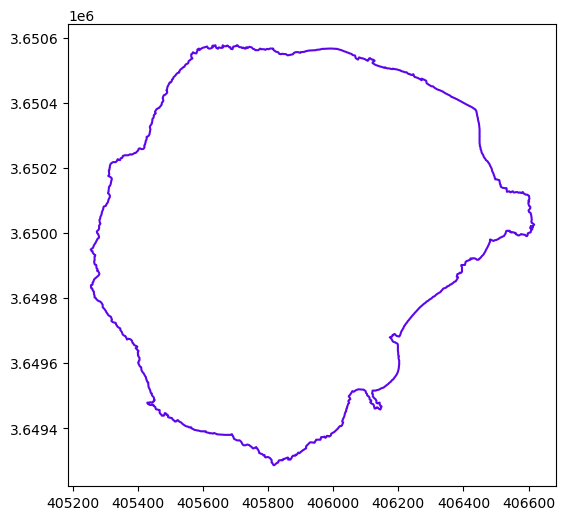

In [11]:
# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start = datetime.date(2012,10,1)
end = datetime.date(2018,10,1)

# Construct and plot the WW object used for storing watersheds
watershed = watershed_workflow.split_hucs.SplitHUCs(shambley)
watershed.plot()

In [12]:
# plot the rivers and watershed
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)


In [13]:
# geometric parameters
simplify = 20 # length scale to target average edge
simplify_rivers = 20
stream_outlet_width = 10 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = None # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.01 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
#num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating

# -- mesh triangle refinement control
refine_d0 = 200
refine_d1 = 600

refine_L0 = 75
refine_L1 = 200

refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

In [14]:
#Paste in the coordinates for the rivers. Include any rivers you plan to refine the mesh around, and the river whose location defines the outlet
reach10 =shapely.geometry.LineString([(405111.41,3649930.45),(405170.69,3649943.88),(405191.42,3649944.28),(405220.13,3649950.09),(405235.37,3649949.32),(405265.9,3649954.5),(405272.16,3649970.9),(405284.47,3649982.36),
                                      (405310.79,3649993.07),(405332.29,3650009.3),(405357.36,3650016.98),(405373.23,3650018.65),(405395.27,3650027.58),(405421.05,3650044.39),(405433.4,3650059.5),(405446.24,3650064.25),
                                      (405470.81,3650082.9),(405484.5,3650087.5)])
                                      
southreach =shapely.geometry.LineString([(406291.5,3649945.5),(406289.5,3649947.5),(406287.5,3649946.5),(406285.5,3649947.5),(406282.5,3649944.5),(406280.5,3649946.5),(406280.5,3649948.5),(406276.5,3649948.5),(406274.5,3649946.5),
                                         (406270.5,3649946.5),(406264.5,3649952.5),(406264.5,3649954.5),(406261.5,3649957.5),(406262.5,3649958.5),(406261.5,3649961.5),(406256.5,3649967.5),(406254.5,3649967.5),(406250.5,3649962.5),
                                         (406248.5,3649962.5),(406246.5,3649964.5),(406241.5,3649965.5),(406238.5,3649967.5),(406237.5,3649966.5),(406233.5,3649966.5),(406230.5,3649963.5),(406227.5,3649965.5),(406226.5,3649969.5),
                                         (406221.5,3649974.5),(406220.5,3649973.5),(406217.5,3649975.5),(406216.5,3649978.5),(406218.5,3649981.5),(406214.5,3649982.5),(406214.5,3649987.5),(406212.5,3649989.5),(406211.5,3649988.5),
                                         (406206.5,3649994.5),(406203.5,3649995.5),(406203.5,3649997.5),(406201.5,3649997.5),(406199.5,3649999.5),(406200.5,3650000.5),(406195.5,3650005.5),(406191.5,3650005.5),(406188.5,3650008.5),
                                         (406185.5,3650009.5),(406183.5,3650012.5),(406183.5,3650014.5),(406180.5,3650017.5),(406170.5,3650027.5),(406161.5,3650032.5),(406159.5,3650037.5),(406158.5,3650036.5),(406154.5,3650037.5),
                                         (406146.5,3650043.5),(406143.5,3650047.5),(406141.5,3650045.5),(406139.5,3650045.5),(406135.5,3650049.5),(406132.5,3650048.5),(406124.5,3650056.5),(406120.5,3650057.5),(406111.5,3650052.5),
                                         (406106.5,3650056.5),(406103.5,3650055.5),(406100.5,3650056.5),(406098.5,3650055.5),(406097.5,3650056.5),(406091.5,3650049.5),(406085.5,3650049.5),(406084.5,3650050.5),(406083.5,3650049.5),
                                         (406082.5,3650050.5),(406075.5,3650044.5),(406069.5,3650049.5),(406066.5,3650050.5),(406064.5,3650049.5),(406062.5,3650050.5),(406056.5,3650050.5),(406054.5,3650048.5),(406051.5,3650049.5),
                                         (406049.5,3650046.5),(406042.5,3650049.5),(406039.5,3650048.5),(406036.5,3650044.5),(406035.5,3650045.5),(406034.5,3650044.5),(406031.5,3650045.5),(406025.5,3650041.5),(406022.5,3650043.5),
                                         (406019.5,3650039.5),(406014.5,3650039.5),(406013.5,3650040.5),(406009.5,3650039.5),(406007.5,3650041.5),(406002.5,3650041.5),(405999.5,3650043.5),(405996.5,3650039.5),(405995.5,3650040.5),
                                         (405993.5,3650039.5),(405990.5,3650041.5),(405982.5,3650035.5),(405979.5,3650034.5),(405977.5,3650031.5),(405966.5,3650030.5),(405964.5,3650027.5),(405959.5,3650028.5),(405956.5,3650025.5),
                                         (405950.5,3650022.5),(405947.5,3650022.5),(405939.5,3650028.5),(405933.5,3650026.5),(405929.5,3650021.5),(405924.5,3650021.5),(405922.5,3650026.5),(405918.5,3650030.5),(405915.5,3650031.5),
                                         (405914.5,3650030.5),(405905.5,3650030.5),(405903.5,3650031.5),(405897.5,3650026.5),(405891.5,3650025.5),(405889.5,3650027.5),(405887.5,3650027.5),(405882.5,3650024.5),(405880.5,3650024.5),
                                         (405877.5,3650027.5),(405874.5,3650027.5),(405872.5,3650025.5),(405867.5,3650028.5),(405863.5,3650028.5),(405862.5,3650027.5),(405860.5,3650029.5),(405857.5,3650028.5),(405853.5,3650032.5),
                                         (405849.5,3650032.5),(405849.5,3650029.5),(405843.5,3650029.5),(405842.5,3650028.5),(405841.5,3650029.5),(405838.5,3650027.5),(405836.5,3650027.5),(405832.5,3650023.5),(405830.5,3650024.5),
                                         (405828.5,3650023.5),(405827.5,3650024.5),(405818.5,3650024.5),(405816.5,3650022.5),(405814.5,3650022.5),(405809.5,3650017.5),(405809.5,3650015.5),(405805.5,3650011.5),(405805.5,3650008.5),
                                         (405803.5,3650006.5),(405800.5,3650004.5),(405796.5,3650007.5),(405791.5,3650002.5),(405788.5,3650002.5),(405785.5,3650000.5),(405784.5,3650001.5),(405777.5,3650001.5),(405774.5,3650004.5),
                                         (405773.5,3650003.5),(405772.5,3650004.5),(405765.5,3650004.5),(405763.5,3650003.5),(405760.5,3650005.5),(405757.5,3650005.5),(405756.5,3650004.5),(405753.5,3650005.5),(405739.5,3650004.5),
                                         (405729.5,3650008.5),(405728.5,3650011.5),(405723.5,3650016.5),(405721.5,3650020.5),(405716.5,3650020.5),(405715.5,3650019.5),(405713.5,3650021.5),(405704.5,3650023.5),(405699.5,3650019.5),
                                         (405696.5,3650021.5),(405694.5,3650021.5),(405692.5,3650023.5),(405688.5,3650023.5),(405686.5,3650025.5),(405680.5,3650021.5),(405677.5,3650022.5),(405676.5,3650021.5),(405675.5,3650022.5),
                                         (405671.5,3650024.5),(405660.5,3650035.5),(405655.52,3650036.48),(405650.5,3650042.5),(405647.52,3650044.48),(405644.5,3650044.5),(405639.5,3650050.5),(405636.5,3650048.5),
                                         (405628.5,3650055.5),(405625.5,3650054.5),(405622.5,3650057.5),(405621.5,3650056.5),(405619.5,3650059.5),(405619.5,3650061.5),(405614.5,3650066.5),(405610.5,3650069.5),(405606.5,3650069.5),                                        
                                         (405605.5,3650068.5),(405602.5,3650072.5),(405603.5,3650074.5),(405600.5,3650079.5),(405597.5,3650078.5),(405592.5,3650082.5),(405589.5,3650082.5),(405585.5,3650085.5),(405579.5,3650086.5),                                         
                                         (405576.5,3650089.5),(405576.5,3650094.5),(405573.5,3650097.5),(405568.5,3650097.5),(405565.5,3650094.5),(405563.5,3650094.5),(405558.5,3650091.5),(405552.5,3650091.5),(405548.5,3650087.5),                                         
                                         (405548.5,3650085.5),(405546.5,3650082.5),(405542.5,3650079.5),(405540.5,3650074.5),(405535.5,3650075.5),(405529.5,3650080.5),(405522.5,3650079.5),(405509.5,3650084.5),(405507.5,3650083.5),
                                         (405503.5,3650086.5),(405501.5,3650084.5),(405499.5,3650086.5),(405489.5,3650086.5),(405485.5,3650088.5),(405484.5,3650087.5)])

centralreach = shapely.geometry.LineString([(406412.5,3650085.5),(406412.5,3650090.5),(406411.5,3650091.5),(406412.5,3650096.5),(406411.5,3650097.5),(406407.5,3650097.5),(406406.5,3650099.5),(406400.5,3650099.5),
                                            (406395.5,3650103.5),(406392.5,3650107.5),(406395.5,3650111.5),(406393.5,3650112.5),(406391.5,3650110.5),(406387.5,3650114.5),(406390.5,3650118.5),(406388.5,3650123.5),
                                            (406385.5,3650126.5),(406383.5,3650126.5),(406379.5,3650129.5),(406375.5,3650136.5),(406371.5,3650134.5),(406364.5,3650140.5),(406362.5,3650146.5),(406360.5,3650146.5),
                                            (406354.5,3650151.5),(406349.5,3650151.5),(406343.5,3650158.5),(406343.5,3650161.5),(406341.5,3650162.5),(406340.5,3650165.5),(406329.5,3650178.5),(406327.5,3650181.5),
                                            (406327.5,3650183.5),(406324.5,3650185.5),(406324.5,3650190.5),(406320.5,3650193.5),(406319.5,3650196.5),(406320.5,3650199.5),(406319.5,3650201.5),(406312.5,3650210.5),
                                            (406311.5,3650215.5),(406304.5,3650222.5),(406304.5,3650224.5),(406301.5,3650228.5),(406301.5,3650232.5),(406295.5,3650240.5),(406294.5,3650247.5),(406293.5,3650248.5),                                        
                                            (406294.5,3650249.5),(406286.5,3650257.5),(406284.5,3650265.5),(406276.5,3650270.5),(406276.5,3650276.5),(406273.5,3650279.5),(406270.5,3650277.5),(406265.5,3650277.5),
                                            (406261.5,3650281.5),(406261.5,3650283.5),(406258.5,3650285.5),(406259.5,3650286.5),(406255.5,3650292.5),(406256.5,3650296.5),(406253.5,3650296.5),(406252.5,3650297.5),
                                            (406253.5,3650302.5),(406241.5,3650316.5),(406240.5,3650321.5),(406236.5,3650324.5),(406236.5,3650327.5),(406233.5,3650330.5),(406228.5,3650327.5),(406225.5,3650328.5),
                                            (406223.5,3650327.5),(406221.5,3650329.5),(406218.5,3650328.5),(406209.5,3650335.5),(406205.5,3650335.5),(406201.5,3650339.5),(406200.5,3650338.5),(406198.5,3650340.5),
                                            (406196.5,3650340.5),(406193.5,3650344.5),(406190.5,3650343.5),(406186.5,3650351.5),(406181.5,3650355.5),(406179.5,3650355.5),(406176.5,3650358.5),(406175.5,3650357.5),
                                            (406172.5,3650357.5),(406172.5,3650361.5),(406168.5,3650365.5),(406167.5,3650364.5),(406159.5,3650369.5),(406155.5,3650369.5),(406154.5,3650371.5),(406151.5,3650372.5),
                                            (406145.5,3650377.5),(406142.5,3650375.5),(406140.5,3650377.5),(406139.5,3650376.5),(406138.5,3650373.5),(406140.5,3650370.5),(406135.5,3650365.5),(406133.5,3650365.5),
                                            (406128.5,3650369.5),(406121.5,3650362.5),(406115.5,3650361.5),(406113.5,3650359.5),(406114.5,3650358.5),(406110.5,3650354.5),(406108.5,3650351.5),(406103.5,3650348.5),
                                            (406097.5,3650342.5),(406097.5,3650339.5),(406094.5,3650336.5),(406094.5,3650334.5),(406092.5,3650332.5),(406090.5,3650332.5),(406089.5,3650329.5),(406084.5,3650324.5),
                                            (406085.5,3650323.5),(406084.5,3650320.5),(406080.5,3650317.5),(406080.5,3650310.5),(406079.5,3650309.5),(406080.5,3650306.5),(406073.5,3650297.5),(406068.5,3650294.5),
                                            (406055.98,3650287.1),(406047.5,3650280.5),(406046.5,3650278.5),(406040.5,3650283.5),(406028.5,3650271.5),(406026.5,3650271.5),(406023.5,3650268.5),(406020.5,3650269.5),
                                            (406018.5,3650267.5),(406017.5,3650268.5),(406011.5,3650267.5),(405992.5,3650254.5),(405990.5,3650255.5),(405987.5,3650254.5),(405985.5,3650255.5),(405982.5,3650252.5),
                                            (405979.5,3650252.5),(405975.5,3650249.5),(405974.5,3650250.5),(405968.5,3650249.5),(405962.5,3650245.5),(405960.5,3650245.5),(405956.5,3650241.5),(405955.5,3650242.5),
                                            (405952.5,3650239.5),(405945.5,3650238.5),(405940.5,3650234.5),(405934.5,3650236.5),(405933.5,3650235.5),(405929.5,3650237.5),(405927.5,3650235.5),(405924.5,3650235.5),
                                            (405916.5,3650227.5),(405903.5,3650215.5),(405895.5,3650212.5),(405886.5,3650203.5),(405881.5,3650206.5),(405877.5,3650205.5),(405871.5,3650211.5),(405867.5,3650211.5),
                                            (405860.5,3650207.5),(405856.5,3650210.5),(405849.5,3650209.5),(405842.5,3650216.5),(405841.5,3650215.5),(405834.5,3650216.5),(405830.5,3650219.5),(405825.5,3650219.5),
                                            (405821.5,3650221.5),(405817.5,3650219.5),(405814.5,3650219.5),(405809.5,3650223.5),(405807.5,3650223.5),(405804.5,3650225.5),(405801.5,3650228.5),(405795.5,3650223.5),
                                            (405790.5,3650227.5),(405787.5,3650226.5),(405779.5,3650235.5),(405772.5,3650230.5),(405768.5,3650230.5),(405767.5,3650229.5),(405765.5,3650230.5),(405763.5,3650228.5),
                                            (405759.5,3650228.5),(405754.5,3650226.5),(405746.5,3650227.5),(405744.5,3650225.5),(405741.5,3650228.5),(405740.5,3650227.5),(405731.5,3650228.5),(405725.5,3650223.5),
                                            (405725.5,3650221.5),(405727.5,3650219.5),(405730.5,3650219.5),(405729.5,3650214.5),(405726.5,3650211.5),(405721.5,3650210.5),(405714.5,3650203.5),(405710.5,3650197.5),
                                            (405707.5,3650198.5),(405703.5,3650197.5),(405694.5,3650188.5),(405694.5,3650186.5),(405690.5,3650180.5),(405684.5,3650175.5),(405682.5,3650176.5),(405676.5,3650176.5),
                                            (405675.5,3650177.5),(405662.5,3650164.5),(405655.5,3650162.5),(405653.5,3650158.5),(405652.5,3650159.5),(405650.5,3650158.5),(405643.5,3650151.5),(405641.5,3650150.5),
                                            (405638.5,3650151.5),(405632.5,3650149.5),(405620.5,3650137.5),(405618.5,3650137.5),(405616.5,3650135.5),(405609.5,3650134.5),(405608.5,3650133.5),(405605.5,3650134.5),
                                            (405602.5,3650133.5),(405591.5,3650143.5),(405590.5,3650142.5),(405588.5,3650142.5),(405585.5,3650139.5),(405582.5,3650140.5),(405580.5,3650138.5),(405578.5,3650138.5),
                                            (405567.5,3650127.5),(405569.5,3650124.5),(405568.5,3650117.5),(405562.5,3650112.5),(405559.5,3650112.5),(405555.5,3650108.5),(405551.5,3650108.5),(405550.5,3650107.5),
                                            (405549.5,3650108.5),(405542.5,3650108.5),(405541.5,3650109.5),(405540.5,3650108.5),(405537.5,3650108.5),(405531.5,3650103.5),(405529.5,3650103.5),(405525.5,3650101.5),
                                            (405522.5,3650099.5),(405515.5,3650105.5),(405513.5,3650105.5),(405509.5,3650101.5),(405505.5,3650099.5),(405497.5,3650099.5),(405492.5,3650097.5),(405488.5,3650097.5),
                                            (405483.5,3650092.5)])
    
    
northreach = shapely.geometry.LineString([(405880.5,3650502.5),(405876.5,3650498.5),(405875.5,3650500.5),(405869.5,3650501.5),(405867.5,3650503.5),(405865.5,3650501.5),(405863.5,3650501.5),(405861.5,3650503.5),(405860.5,3650502.5),
                                          (405855.5,3650502.5),(405853.5,3650504.5),(405850.5,3650502.5),(405847.5,3650502.5),(405846.5,3650503.5),(405845.5,3650502.5),(405842.5,3650502.5),(405840.5,3650500.5),(405838.5,3650504.5),
                                          (405833.5,3650504.5),(405823.5,3650496.5),(405819.5,3650497.5),(405816.5,3650492.5),(405814.5,3650493.5),(405812.5,3650491.5),(405810.5,3650493.5),(405809.5,3650492.5),(405806.5,3650493.5),
                                          (405800.5,3650491.5),(405798.5,3650492.5),(405795.5,3650491.5),(405793.5,3650487.5),(405790.5,3650487.5),(405788.5,3650489.5),(405785.5,3650485.5),(405783.5,3650484.5),(405776.5,3650484.5),
                                          (405775.5,3650482.5),(405770.5,3650480.5),(405767.5,3650481.5),(405766.5,3650480.5),(405764.5,3650481.5),(405758.5,3650480.5),(405756.5,3650482.5),(405753.5,3650481.5),(405750.5,3650477.5),
                                          (405746.5,3650477.5),(405739.5,3650472.5),(405736.5,3650469.5),(405736.5,3650466.5),(405732.5,3650466.5),(405731.5,3650464.5),(405728.5,3650464.5),(405727.5,3650463.5),(405725.5,3650463.5),
                                          (405724.5,3650465.5),(405725.5,3650467.5),(405724.5,3650468.5),(405718.5,3650468.5),(405717.5,3650469.5),(405715.5,3650469.5),(405710.5,3650464.5),(405704.5,3650464.5),(405702.5,3650466.5),
                                          (405700.5,3650466.5),(405696.5,3650463.5),(405691.5,3650467.5),(405688.5,3650465.5),(405685.5,3650467.5),(405683.5,3650465.5),(405684.5,3650462.5),(405681.5,3650460.5),(405680.5,3650457.5),
                                          (405682.5,3650455.5),(405681.5,3650454.5),(405679.5,3650454.5),(405673.5,3650448.5),(405670.5,3650449.5),(405667.5,3650444.5),(405661.5,3650444.5),(405660.5,3650439.5),(405658.5,3650438.5),
                                          (405655.5,3650437.5),(405652.5,3650437.5),(405650.5,3650439.5),(405648.5,3650438.5),(405640.5,3650429.5),(405636.5,3650425.5),(405638.5,3650423.5),(405638.5,3650421.5),(405640.5,3650420.5),
                                          (405637.5,3650415.5),(405634.5,3650416.5),(405631.5,3650419.5),(405629.5,3650417.5),(405625.5,3650416.5),(405622.5,3650413.5),(405623.5,3650410.5),(405612.5,3650400.5),(405612.5,3650397.5),
                                          (405615.5,3650395.5),(405615.5,3650391.5),(405617.5,3650390.5),(405617.5,3650387.5),(405613.5,3650384.5),(405612.5,3650385.5),(405610.5,3650384.5),(405605.5,3650387.5),(405598.5,3650381.5),
                                          (405597.5,3650375.5),(405600.5,3650373.5),(405600.5,3650367.5),(405603.5,3650364.5),(405603.5,3650361.5),(405606.5,3650360.5),(405606.5,3650359.5),(405602.5,3650355.5),(405603.5,3650352.5),
                                          (405601.5,3650350.5),(405594.5,3650345.5),(405592.5,3650347.5),(405589.5,3650346.5),(405586.5,3650343.5),(405586.5,3650341.5),(405580.5,3650335.5),(405578.5,3650335.5),(405576.5,3650333.5),
                                          (405578.5,3650331.5),(405578.5,3650328.5),(405574.5,3650324.5),(405575.5,3650323.5),(405574.5,3650319.5),(405568.5,3650313.5),(405567.5,3650309.5),(405563.5,3650307.5),(405564.5,3650305.5),
                                          (405560.5,3650301.5),(405559.5,3650299.5),(405560.5,3650298.5),(405553.5,3650290.5),(405554.5,3650287.5),(405549.5,3650281.5),(405552.5,3650276.5),(405548.5,3650271.5),(405548.5,3650268.5),
                                          (405544.5,3650265.5),(405544.5,3650263.5),(405548.5,3650260.5),(405546.5,3650256.5),(405547.5,3650255.5),(405546.5,3650252.5),(405547.5,3650250.5),(405544.5,3650246.5),(405546.5,3650242.5),
                                          (405546.5,3650239.5),(405545.5,3650238.5),(405546.5,3650236.5),(405544.5,3650234.5),(405546.5,3650229.5),(405544.5,3650227.5),(405544.5,3650223.5),(405541.5,3650219.5),(405541.5,3650217.5),
                                          (405538.5,3650214.5),(405539.5,3650212.5),(405538.5,3650209.5),(405539.5,3650207.5),(405538.5,3650206.5),(405540.5,3650202.5),(405538.5,3650199.5),(405540.5,3650196.5),(405537.5,3650193.5),
                                          (405537.5,3650189.5),(405541.5,3650187.5),(405540.5,3650185.5),(405542.5,3650182.5),(405540.5,3650179.5),(405538.5,3650179.5),(405534.5,3650176.5),(405534.5,3650174.5),(405536.5,3650171.5),
                                          (405535.5,3650165.5),(405533.5,3650163.5),(405533.5,3650159.5),(405534.5,3650158.5),(405530.5,3650153.5),(405528.5,3650144.5),(405527.5,3650143.5),(405525.5,3650144.5),(405521.5,3650141.5),
                                          (405520.5,3650137.5),(405517.5,3650135.5),(405516.5,3650126.5),(405509.5,3650123.5),(405507.5,3650124.5),(405496.5,3650111.5),(405493.5,3650111.5),(405492.5,3650110.5),(405489.5,3650106.5),
                                          (405490.5,3650103.5),(405487.5,3650100.5),(405488.5,3650098.5),(405483.5,3650092.5)])

In [15]:
#reaches = gpd.GeoDataFrame()
#reaches.geometry = [reach10, centralreach]  
#rivers = watershed_workflow.river_tree.createRivers(reaches, method='geometry')

#store the unsimplified, undensified version of the river network
#rivers_orig=[river.deepcopy() for river in rivers]
#shambley_orig = watershed.deepcopy()


In [16]:
reaches = gpd.read_file(('Shapes/r_fac_streams_v2.shp'))
rivers = watershed_workflow.river_tree.createRivers(reaches, method='geometry')

rivers_orig=[river.deepcopy() for river in rivers]
shambley_orig = watershed.deepcopy()

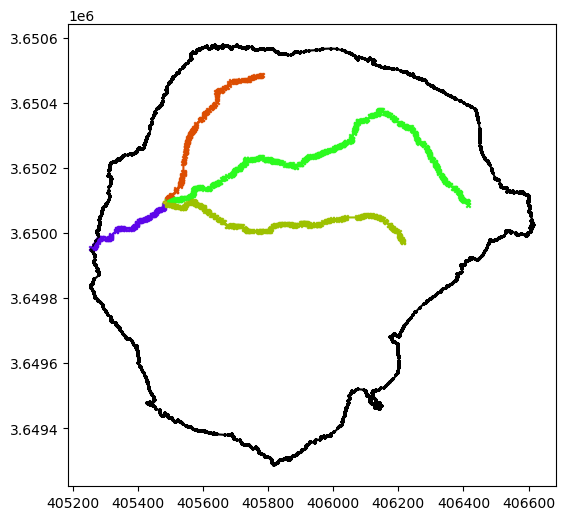

In [17]:
plot(watershed, rivers)

2026-02-20 16:43:00,048 - root - INFO: 
2026-02-20 16:43:00,050 - root - INFO: Simplifying
2026-02-20 16:43:00,050 - root - INFO: ------------------------------
2026-02-20 16:43:00,051 - root - INFO: EPSG:32616
2026-02-20 16:43:00,055 - root - INFO: Presimplify to remove colinear, coincident points.
2026-02-20 16:43:00,074 - root - INFO: EPSG:32616
2026-02-20 16:43:00,086 - root - INFO: Pruning leaf reaches < 20
2026-02-20 16:43:00,092 - root - INFO: EPSG:32616
2026-02-20 16:43:00,099 - root - INFO: Merging internal reaches < 20
2026-02-20 16:43:00,105 - root - INFO:   ...cleaned inner linestring of length 11.4853 at centroid (405484.8034563334, 3650093.2886178335) with id np.int64(3)
2026-02-20 16:43:00,107 - root - INFO: EPSG:32616
2026-02-20 16:43:00,113 - root - INFO:   reach: min seg length: 	    0.9999999963 	min geom length: 	  319.9603830578
2026-02-20 16:43:00,114 - root - INFO:   reach: med seg length: 	    1.4142135630 	med geom length: 	  749.1080266212
2026-02-20 16:43:00,

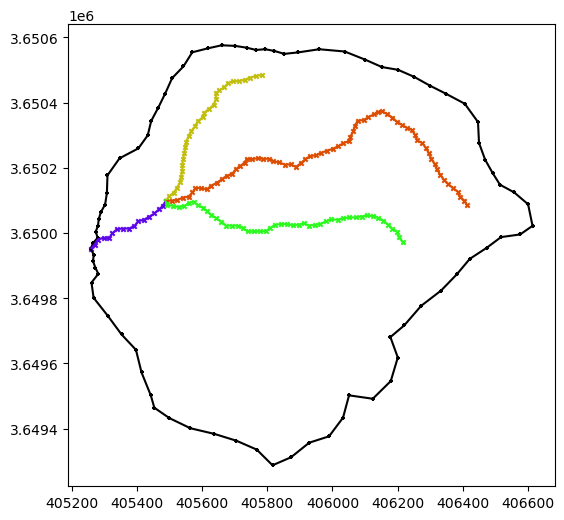

In [18]:
# simplifying -- this sets the discrete length scale of both the watershed boundary and the rivers
#watershed_workflow.simplify(watershed, rivers, refine_L0, refine_L1, 8, 20)
watershed_workflow.simplify(watershed, rivers, 20, 80, 60, 200)

plot(watershed, rivers)

In [19]:
# ETC: NOTE -- can this be moved into the simplify call?
for river in rivers:
    river.resetDataFrame()

# Now that the river network is set, find the watershed boundary outlets
for river in rivers:
    watershed_workflow.hydrography.findOutletsByCrossings(watershed, river)

2026-02-20 16:43:00,640 - root - INFO: Crossings by Polygon:
2026-02-20 16:43:00,641 - root - INFO:   Polygon 0
2026-02-20 16:43:00,641 - root - INFO:     crossing: [ 405257.80130944 3649951.342522  ]
2026-02-20 16:43:00,642 - root - INFO: Constructing outlet list
2026-02-20 16:43:00,642 - root - INFO: Iteration = 0
2026-02-20 16:43:00,643 - root - INFO: -----------------
2026-02-20 16:43:00,643 - root - INFO:  poly outlet 0 : 0, [ 405257.80130944 3649951.342522  ]
2026-02-20 16:43:00,644 - root - INFO: last outlet is 0 in polygon 0 at {crossings_clusters_centroids[last_outlet]}


2026-02-20 16:43:00,669 - root - INFO: 
2026-02-20 16:43:00,669 - root - INFO: Stream-aligned Meshing
2026-02-20 16:43:00,670 - root - INFO: ------------------------------
2026-02-20 16:43:00,670 - root - INFO: Creating stream-aligned mesh...
2026-02-20 16:43:00,701 - root - INFO: Adjusting HUC to match reaches at outlet
2026-02-20 16:43:00,706 - root - INFO: 
2026-02-20 16:43:00,707 - root - INFO: Triangulation
2026-02-20 16:43:00,707 - root - INFO: ------------------------------
2026-02-20 16:43:00,717 - root - INFO: Triangulating...
2026-02-20 16:43:00,718 - root - INFO:    398 points and 399 facets
2026-02-20 16:43:00,718 - root - INFO:  checking graph consistency
2026-02-20 16:43:00,719 - root - INFO:  tolerance is set to 0.1
2026-02-20 16:43:00,721 - root - INFO:  building graph data structures
2026-02-20 16:43:00,721 - root - INFO:  triangle.build...
2026-02-20 16:43:01,065 - root - INFO:   ...built: 2511 mesh points and 4618 triangles
2026-02-20 16:43:01,066 - root - INFO: Plot

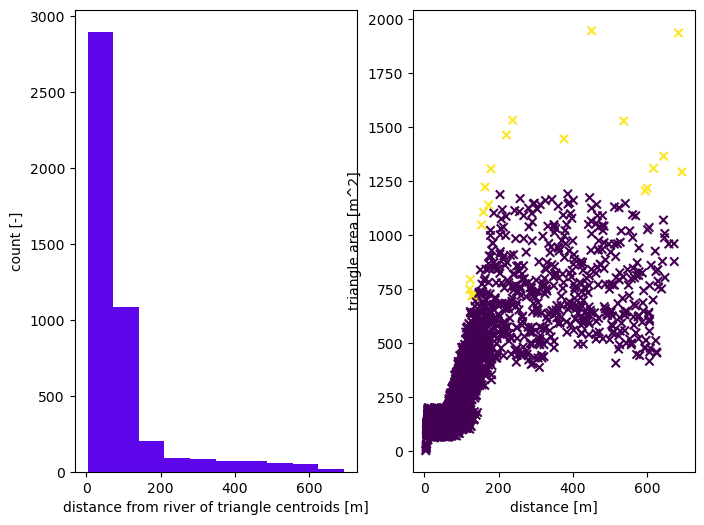

In [20]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 60; d1 = 200
A0 = 200; A1 = 1200



# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
m2, areas, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=8,
                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
                                              tol=0.1, diagnostics=True)

#m2, areas, dists = watershed_workflow.triangulate(watershed, rivers,
#                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
#                                              tol=0.1, diagnostics=True)

In [21]:
# get a raster for the elevation map, 1 meter DEM)
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)['band_1']

print(type(dem))
watershed_workflow.elevate(m2, dem)
# elevate the triangle nodes to the dem
#mesh_points3 = watershed_workflow.elevate(mesh_# Plot the DEM raster

# construct the 2D mesh
#m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris ,points2, crsw, dem, dem_profile)

2026-02-20 16:43:01,433 - root - INFO: Incoming shape area = 1578320.3352318944
2026-02-20 16:43:01,434 - root - INFO: ... buffering incoming shape by = 1.0
2026-02-20 16:43:01,435 - root - INFO: ... buffered shape area = 1583088.2223433538


<class 'xarray.core.dataarray.DataArray'>


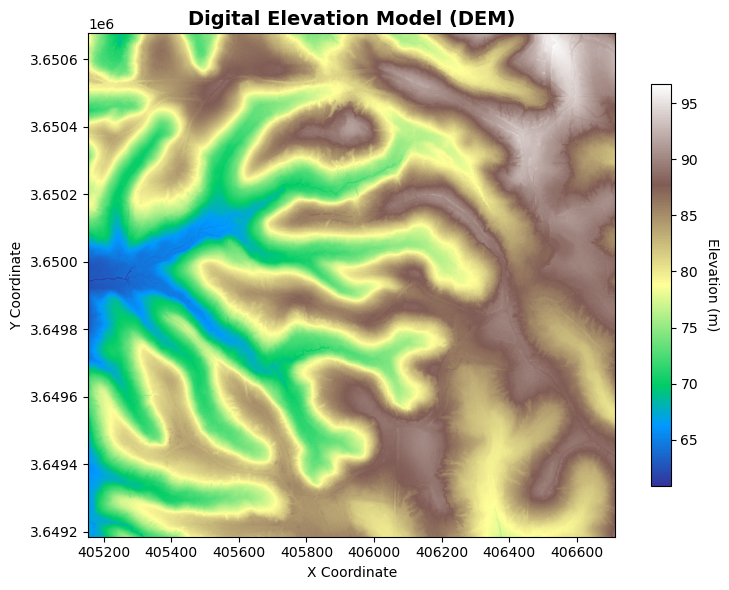

In [22]:
fig, ax = plt.subplots()
# Plot the DEM data
im = dem.plot(ax=ax, cmap='terrain', add_colorbar=False)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Elevation (m)', rotation=270, labelpad=15)

# Add title and labels
ax.set_title('Digital Elevation Model (DEM)', fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set equal aspect ratio
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [23]:
# hydrologically condition the mesh, removing pits
#river_mask=np.zeros((len(m2.conn)))
#for i, elem in enumerate(m2.conn):
#    if not len(elem)==3:
#        river_mask[i]=1     
#watershed_workflow.condition.fillPitsDual(m2, is_waterbody=river_mask)

In [24]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.setProfileByDEM(rivers, dem)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.conditionRiverMesh(m2, rivers[0])

In [25]:
southWat_shapefile = watershed_workflow.sources.ManagerShapefile('largerWatersheds/SouthWatershedPoly.shp')
southWat = southWat_shapefile.getShapes(out_crs=crs)
southWat.rename(columns={'AREA' : names.AREA}, inplace=True)
southWat_HUC = watershed_workflow.split_hucs.SplitHUCs(southWat)

centWat_shapefile = watershed_workflow.sources.ManagerShapefile('largerWatersheds/CentralWatershedPoly.shp')
centWat = centWat_shapefile.getShapes(out_crs=crs)
centWat.rename(columns={'AREA' : names.AREA}, inplace=True)
centWat_HUC = watershed_workflow.split_hucs.SplitHUCs(centWat)

northWat_shapefile = watershed_workflow.sources.ManagerShapefile('largerWatersheds/NorthWatershedPoly.shp')
northWat = northWat_shapefile.getShapes(out_crs=crs)
northWat.rename(columns={'AREA' : names.AREA}, inplace=True)
northWat_HUC = watershed_workflow.split_hucs.SplitHUCs(northWat)


2026-02-20 16:43:02,677 - root - INFO: fixing column: geometry
2026-02-20 16:43:02,688 - root - INFO: Removing holes on 1 polygons
2026-02-20 16:43:02,689 - root - INFO:   -- removed interior
2026-02-20 16:43:02,690 - root - INFO:   -- union
2026-02-20 16:43:02,691 - root - INFO: Parsing 1 components for holes
2026-02-20 16:43:02,691 - root - INFO:   -- complete
2026-02-20 16:43:02,699 - root - INFO: fixing column: geometry
2026-02-20 16:43:02,710 - root - INFO: Removing holes on 1 polygons
2026-02-20 16:43:02,711 - root - INFO:   -- removed interior
2026-02-20 16:43:02,711 - root - INFO:   -- union
2026-02-20 16:43:02,712 - root - INFO: Parsing 1 components for holes
2026-02-20 16:43:02,712 - root - INFO:   -- complete
2026-02-20 16:43:02,721 - root - INFO: fixing column: geometry
2026-02-20 16:43:02,723 - root - INFO: Removing holes on 1 polygons
2026-02-20 16:43:02,723 - root - INFO:   -- removed interior
2026-02-20 16:43:02,724 - root - INFO:   -- union
2026-02-20 16:43:02,724 - ro

In [26]:
#southFlume_shapefile = watershed_workflow.sources.ManagerShapefile('largerWatersheds/southFlumeWatershed.shp')
south_Flume_gdf = gpd.read_file('largerWatersheds/southFlumeWatershed.shp')
south_Flume_gdf = south_Flume_gdf.set_crs(watershed.crs)
south_Flume_geom = south_Flume_gdf.geometry.iloc[0]
if isinstance(south_Flume_geom, MultiPolygon):
    print("MultiPolygon")
    southFlume = south_Flume_geom.geoms[0]
else: southFlume = south_Flume_geom
southFlume_out = shapely.geometry.Point(405853.36,3650027.50)


central_Flume_gdf = gpd.read_file('largerWatersheds/centralFlumeWatershed.shp')
central_Flume_gdf = central_Flume_gdf.set_crs(watershed.crs)
central_Flume_geom = central_Flume_gdf.geometry.iloc[0]
if isinstance(central_Flume_geom, MultiPolygon):
    print("MultiPolygon")
    centralFlume = central_Flume_geom.geoms[0]
else: centralFlume = central_Flume_geom
centralFlume_out = shapely.geometry.Point(405754.49,3650226.49)

In [27]:
# Import HGUs for South Watershed
south_Inc_gdf = gpd.read_file('ReachRedo/southincised.shp')
print(south_Inc_gdf)
south_Inc_gdf  = south_Inc_gdf.to_crs(watershed.crs)
southInc_geom = south_Inc_gdf.geometry.iloc[0]
if isinstance(southInc_geom, MultiPolygon):
    print("MultiPolygon")
    southInc = southInc_geom.geoms[0]
else: southInc = southInc_geom
south_Inc_out = shapely.geometry.Point(405594.60, 3650083.86)

south_Typ_gdf = gpd.read_file('ReachRedo/southtypical.shp')
south_Typ_gdf  = south_Typ_gdf.to_crs(watershed.crs)
southTyp_geom = south_Typ_gdf.geometry.iloc[0]
if isinstance(southTyp_geom, MultiPolygon):
    print("MultiPolygon")
    southTyp = southTyp_geom.geoms[0]
else: southTyp = southTyp_geom
south_Typ_out = shapely.geometry.Point(405927.96, 3650025.37)

south_Wet_gdf = gpd.read_file('ReachRedo/southwetland.shp')
south_Wet_gdf  = south_Wet_gdf.to_crs(watershed.crs)
southWet_geom = south_Wet_gdf.geometry.iloc[0]
if isinstance(southWet_geom, MultiPolygon):
    print("MultiPolygon")
    southTyp = southWet_geom.geoms[0]
else: southWet = southWet_geom
south_Wet_out = shapely.geometry.Point(406063.13, 3650050.50)


   Id  gridcode   Shape_Leng    Shape_Area  \
0   1         1  1351.862112  14371.712052   

                                            geometry  
0  POLYGON ((405610.256 3650041.351, 405653.111 3...  


In [28]:
# Import HGUs for Large Watershed
central_Inc_gdf = gpd.read_file('ReachRedo/centralincised1.shp')
central_Inc_gdf  = central_Inc_gdf.to_crs(watershed.crs)
centralInc_geom = central_Inc_gdf.geometry.iloc[0]
if isinstance(centralInc_geom, MultiPolygon):
    print("MultiPolygon")
    centralInc = centralInc_geom.geoms[0]
else: centralInc = centralInc_geom
central_Inc_out = shapely.geometry.Point(405626.12, 3650143.12)

central_Typ_gdf = gpd.read_file('ReachRedo/centraltypical.shp')
central_Typ_gdf  = central_Typ_gdf.to_crs(watershed.crs)
centralTyp_geom = central_Typ_gdf.geometry.iloc[0]
if isinstance(centralTyp_geom, MultiPolygon):
    print("MultiPolygon")
    centralTyp = centralTyp_geom.geoms[0]
else: centralTyp = centralTyp_geom
central_Typ_out = shapely.geometry.Point(406263.88, 3650283.47)

central_Wet_gdf = gpd.read_file('ReachRedo/centralwetland.shp')
central_Wet_gdf  = central_Wet_gdf.to_crs(watershed.crs)
centralWet_geom = central_Wet_gdf.geometry.iloc[0]
if isinstance(centralWet_geom, MultiPolygon):
    print("MultiPolygon")
    centralWet = centralWet_geom.geoms[0]
else: centralWet = centralWet_geom
central_Wet_out = shapely.geometry.Point(406046.25, 3650283.46)

In [29]:
# Import HGUs for North Watershed
north_Typ1_gdf = gpd.read_file('ReachRedo/northtypical1.shp')
north_Typ1_gdf  = north_Typ1_gdf.to_crs(watershed.crs)
north_Typ1_geom = north_Typ1_gdf.geometry.iloc[0]
if isinstance(north_Typ1_geom, MultiPolygon):
    print("MultiPolygon")
    northTyp1 = north_Typ1_geom.geoms[0]
else: northTyp1 = north_Typ1_geom
north_Typ1_out = shapely.geometry.Point(405540.63, 3650191.09)

north_Typ2_gdf = gpd.read_file('ReachRedo/northtypical2.shp')
north_Typ2_gdf  = north_Typ2_gdf.to_crs(watershed.crs)
north_Typ2_geom = north_Typ2_gdf.geometry.iloc[0]
if isinstance(north_Typ2_geom, MultiPolygon):
    print("MultiPolygon")
    northTyp2 = north_Typ2_geom.geoms[0]
else: northTyp2 = north_Typ2_geom
north_Typ2_out = shapely.geometry.Point(405709.33, 3650465.38)

north_Wet_gdf = gpd.read_file('ReachRedo/northwetland.shp')
north_Wet_gdf  = north_Wet_gdf.to_crs(watershed.crs)
north_Wet_geom = north_Wet_gdf.geometry.iloc[0]
if isinstance(north_Wet_geom, MultiPolygon):
    print("MultiPolygon")
    northWet = north_Wet_geom.geoms[0]
else: northWet = north_Wet_geom
north_Wet_out = shapely.geometry.Point(405597.26, 3650347.47)

In [30]:
reachShapes = [southInc, southTyp, southWet, centralInc, centralWet, centralTyp, northTyp1, 
               northTyp2, northWet, southFlume, centralFlume]

reachOuts = [south_Inc_out, south_Typ_out, south_Wet_out, central_Inc_out, central_Wet_out, 
             central_Typ_out, north_Typ1_out, north_Typ2_out, north_Wet_out, southFlume_out, centralFlume_out]

reachLabels = ["South_Inc","South_Typ","South_Wet", "Central_Inc", "Central_Wet", "Central_Typ",
               "North_Typ1", "North_Typ2", "North_Wet", "South_Flume", "Central_Flume"]

2026-02-20 16:43:03,432 - matplotlib.axes._base - WARNING: Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


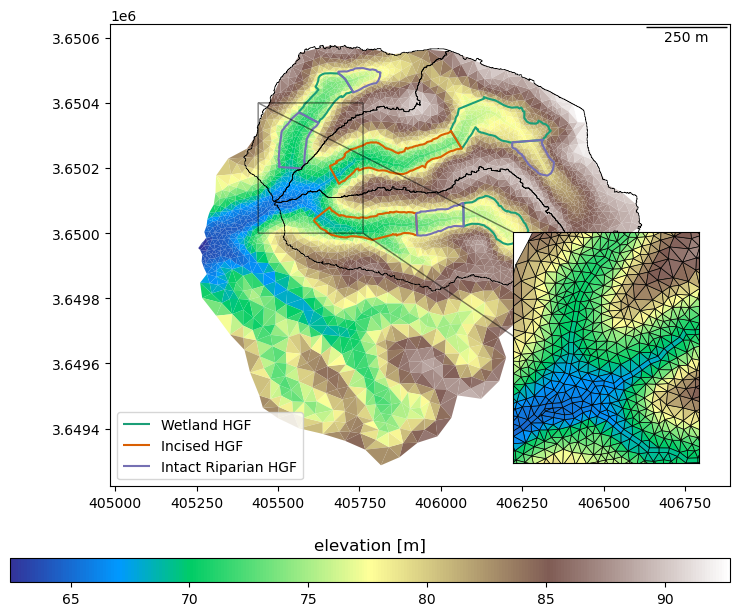

In [31]:

# plotting surface mesh with elevations
fig, ax = plt.subplots()
cbax = fig.add_axes([0.00,-0.05,0.9,0.04])

mp = m2.plot(facecolors='elevation', edgecolors=None, ax=ax, linewidth=0.5, colorbar=False)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
#ax.set_title('Shambley Creek Subwatersheds and HGFs')
ax.set_aspect('equal', 'datalim')

northplot_wet = north_Wet_gdf.boundary.plot(ax=ax, color='#1b9e77')
northplot_typ1 = north_Typ1_gdf.boundary.plot(ax=ax, color='#7570b3')
northplot_typ2  = north_Typ2_gdf.boundary.plot(ax=ax, color='#7570b3')

southplot_wet = south_Wet_gdf.boundary.plot(ax=ax, color='#1b9e77', label='Wetland HGF')
southplot_inc = south_Inc_gdf.boundary.plot(ax=ax, color='#d95f02', label='Incised HGF')
southplot_typ = south_Typ_gdf.boundary.plot(ax=ax, color='#7570b3', label = 'Intact Riparian HGF')

centralplot_wet = central_Wet_gdf.boundary.plot(ax=ax, color='#1b9e77')
centralplot_inc = central_Inc_gdf.boundary.plot(ax=ax, color='#d95f02')
centralplot_typ = central_Typ_gdf.boundary.plot(ax=ax, color='#7570b3')



northwat_plot = northWat_HUC.plot(ax=ax, color='k',linewidth=0.5)
centralwat_plot = centWat_HUC.plot(ax=ax, color='k',linewidth=0.5)
southwat_plot = southWat_HUC.plot(ax=ax, color='k',linewidth=0.5)

scalebar = AnchoredSizeBar(ax.transData,
                           250, '250 m', 'upper right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1)
ax.add_artist(scalebar)


ax.legend(loc="lower left")

ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])

mp2 = m2.plot(facecolors='elevation', edgecolors='k', ax=ax2, colorbar=False)
ax2.set_aspect('equal', 'datalim')

xlim = (405450, 405750)
ylim = (3650000, 3650400)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')


cbar.ax.set_title('elevation [m]')

plt.savefig("Figure1.tiff", dpi=300)
#plt.savefig('Domain.png', bbox_inches='tight')
plt.show()

In [32]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs)['cover']

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

2026-02-20 16:43:03,906 - root - INFO: Incoming shape area = 0.0001523450167715333
2026-02-20 16:43:03,907 - root - INFO: ... buffering incoming shape by = 0.00027
2026-02-20 16:43:03,907 - root - INFO: ... buffered shape area = 0.0001653088326263012
2026-02-20 16:43:05,828 - root - INFO: Found land cover dtypes: uint8
2026-02-20 16:43:05,829 - root - INFO: Found land cover types: {np.uint8(71), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81), np.uint8(52), np.uint8(90), np.uint8(127)}


making colormap with: [np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(90), np.uint8(127)]
making colormap with colors: [(0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.8862745098, 0.8862745098, 0.7568627451), (0.85882352941, 0.84705882353, 0.23921568628), (0.72941176471, 0.84705882353, 0.91764705882), (1.0, 1.0, 1.0)]


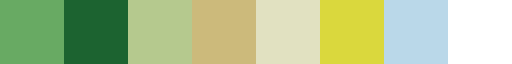

In [33]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

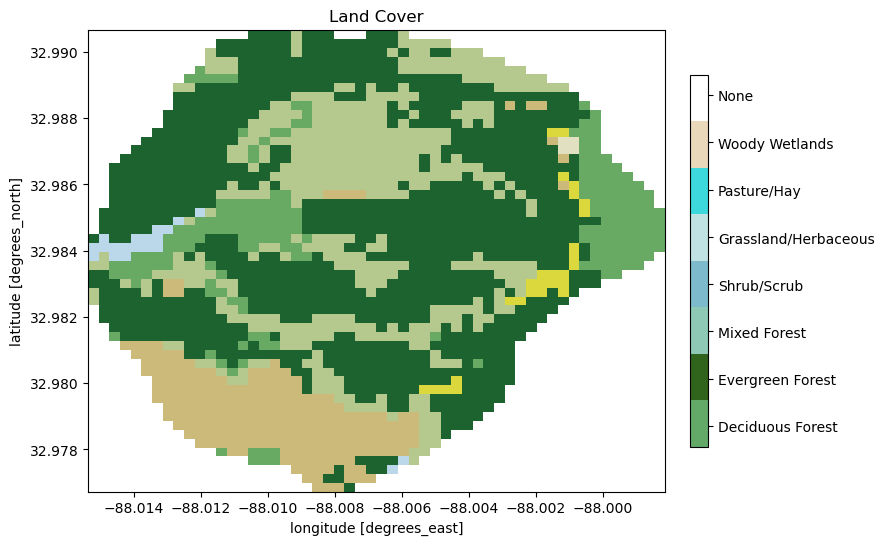

In [34]:
fig, ax = plt.subplots(1,1)
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
ax.set_title('Land Cover')
plt.show()

In [35]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data = {}
m2.cell_data["land_cover"] = m2_nlcd

In [36]:
# double-check that nan not in the values
assert 127 not in m2_nlcd
assert len(m2_nlcd) == m2.num_cells
# create a new set of labels and indices with only those that actually appear on the mesh
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(m2_nlcd))


making colormap with: [np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(81), np.uint8(90)]
making colormap with colors: [(0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.85882352941, 0.84705882353, 0.23921568628), (0.72941176471, 0.84705882353, 0.91764705882)]


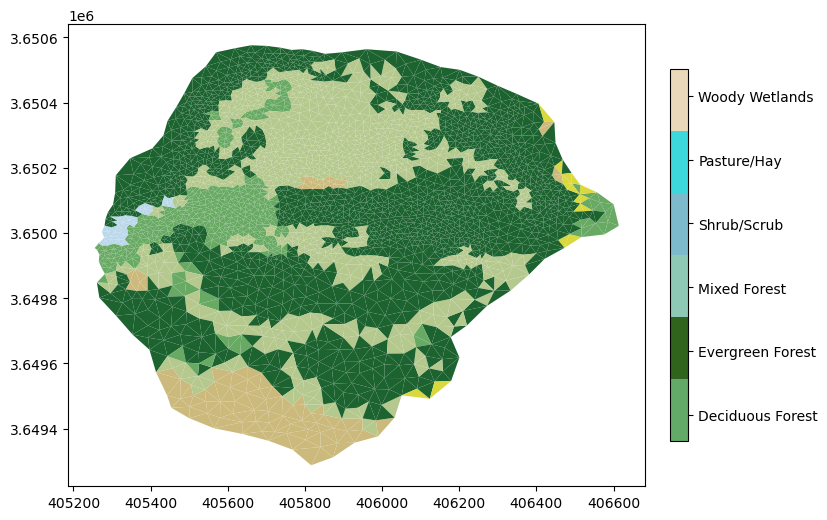

In [37]:
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=plt.gca()) 
plt.show()

In [38]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [39]:
#watershed_modis_lai = 'WeyerLeaf/shambleyLAI_500m_aid0001.nc'
#watershed_modis_lulc = 'WeyerLeaf/shambleyLULC_500m_aid0001.nc'

import watershed_workflow.config as cfg
cfg.rcParams["AppEEARS"]["username"] = "akirker"
cfg.rcParams["AppEEARS"]["password"] = "fh465pZtd6&i"


start_leap = cftime.DatetimeGregorian(start.year, start.month, start.day)
end_leap = cftime.DatetimeGregorian(end.year, end.month, end.day)

                                  
                                  #variables = ['LAI','LULC'], filenames=[watershed_modis_lai, watershed_modis_lulc])

# resample the raster to the triangles
#modis_lc = watershed_workflow.values_from_raster(m2.centroids, crsw, modis['LULC'].data[0,:,:], 
#                                                 modis['LULC'].profile)
# what land cover types did we get?
#logging.info('Found land cover dtypes: {}'.format(modis_lc.dtype))
#logging.info('Found land cover types: {}'.format(set(modis_lc)))

In [40]:
res = sources['LAI'].getDataset(watershed.exterior, crs, start_leap, end_leap)


2026-02-20 16:43:06,768 - root - INFO: Incoming shape area = 0.0001090799083422309
2026-02-20 16:43:06,769 - root - INFO: ... buffering incoming shape by = 0.0045000000000000005
2026-02-20 16:43:06,769 - root - INFO: ... buffered shape area = 0.00035599967938890545
2026-02-20 16:43:06,770 - root - INFO: Building request for bounds: [np.float64(-88.0185), np.float64(32.9734), np.float64(-87.995), np.float64(32.994)]
2026-02-20 16:43:06,770 - root - INFO: ... requires files:
2026-02-20 16:43:06,772 - root - INFO:  ... /home/jovyan/workdir/Kirker_WW/data/land_cover/MODIS/modis_LAI_10-01-2012_10-01-2018_32.9940x-88.0185_32.9734x-87.9950.nc
2026-02-20 16:43:06,772 - root - INFO:  ... /home/jovyan/workdir/Kirker_WW/data/land_cover/MODIS/modis_LULC_10-01-2012_10-01-2018_32.9940x-88.0185_32.9734x-87.9950.nc
2026-02-20 16:43:06,773 - root - INFO: ... files exist locally.


In [41]:
modis_data = res
assert modis_data['LAI'].rio.crs is not None

In [42]:
# MODIS data comes with time-dependent LAI AND time-dependent LULC -- just take the mode to find the most common LULC
modis_data['LULC'] = watershed_workflow.data.computeMode(modis_data['LULC'], 'time_LULC')

# now it is safe to have only one time
modis_data = modis_data.rename({'time_LAI':'time'})

# remove leap day (366th day of any leap year) to match our Noleap Calendar
modis_data = watershed_workflow.data.filterLeapDay(modis_data)

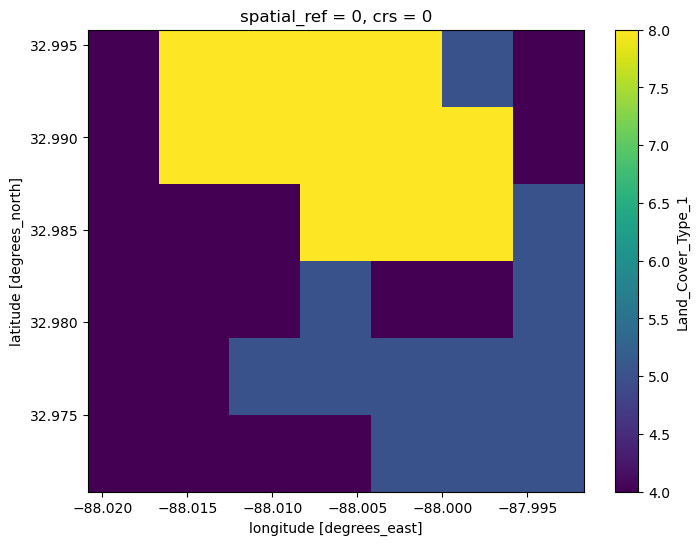

In [43]:
# plot the MODIS data -- 
modis_data['LULC'].plot.imshow()

In [44]:
# compute the transient time series
modis_lai = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

In [45]:
modis_lai

,time,Deciduous Broadleaf Forests LAI [-],Mixed Forests LAI [-],Woody Savannas LAI [-]
0,2012-09-30 00:00:00,6.70,1.0,1.1
1,2012-10-04 00:00:00,2.30,2.4,1.8
2,2012-10-08 00:00:00,2.70,3.0,2.2
3,2012-10-12 00:00:00,2.20,2.3,2.3
4,2012-10-16 00:00:00,2.05,2.1,2.1
...,...,...,...,...
546,2018-09-14 00:00:00,2.95,3.5,3.9
547,2018-09-18 00:00:00,3.00,3.0,3.3
548,2018-09-22 00:00:00,1.40,2.2,2.2
549,2018-09-26 00:00:00,0.65,0.7,0.7


2026-02-20 16:43:07,455 - root - INFO: Writing HDF5 file: output_data/Shambley_LAI_MODIS_transient.h5


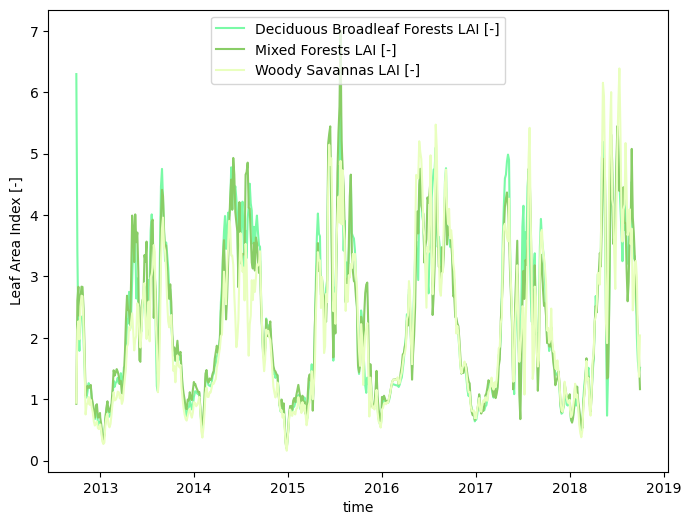

In [46]:
# smooth the data in time
modis_lai_smoothed = watershed_workflow.data.smoothTimeSeries(modis_lai, 'time')

# save the MODIS time series to disk
output_filenames['modis_lai_transient'] = toOutput(f'{name}_LAI_MODIS_transient.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_transient'], modis_lai_smoothed)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_smoothed, indices='MODIS')

2026-02-20 16:43:07,667 - root - INFO: Writing HDF5 file: output_data/Shambley_LAI_MODIS_CyclicSteadystate.h5


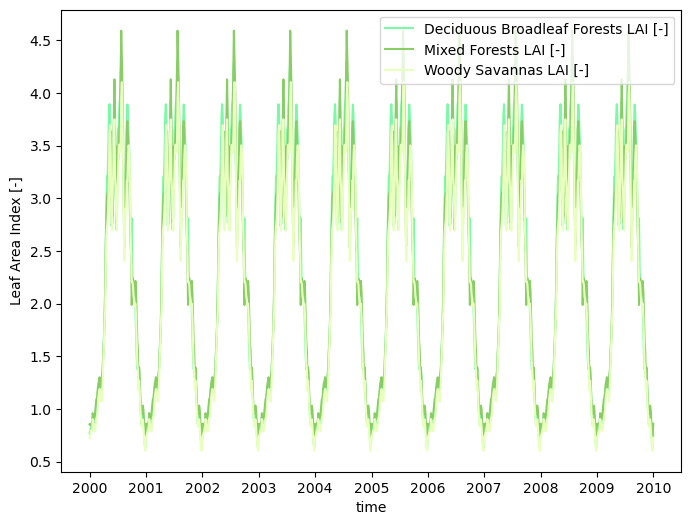

In [47]:
# compute a typical year
modis_lai_typical = watershed_workflow.data.computeAverageYear(modis_lai_smoothed, 'time', output_nyears=10, 
                                                                  start_year=2000)

output_filenames['modis_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_MODIS_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['modis_lai_cyclic_steadystate'], modis_lai_typical)
watershed_workflow.land_cover_properties.plotLAI(modis_lai_typical, indices='MODIS')

2026-02-20 16:43:07,805 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2026-02-20 16:43:07,805 - root - INFO:   unique MODIS: [np.float64(4.0), np.float64(5.0), np.float64(8.0)]
2026-02-20 16:43:07,806 - root - INFO:   unique NLCD: [np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(90)]


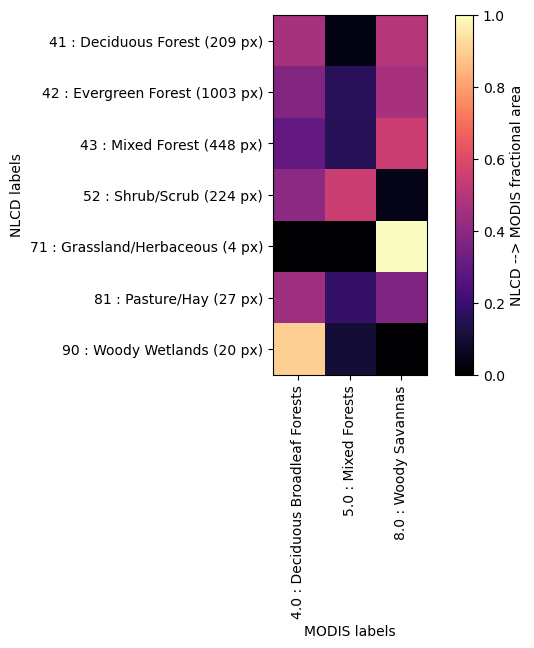

In [48]:
# determine a crosswalk between NLCD and MODIS -- for each NLCD index, 
# what MODIS index correlates best.  
crosswalk = watershed_workflow.land_cover_properties.computeCrosswalk(modis_data['LULC'], nlcd, method='fractional area')

In [49]:
# Deal with the Woody Savannas
woody_code = 8  # MODIS code for Woody Savannas
target_code = 5 # Mixed Forests

# Remap crosswalk
crosswalk_remap = {}
for nlcd_id, parts in crosswalk.items():
    new_parts = [(target_code if p[0]==woody_code else p[0], p[1]) for p in parts]
    crosswalk_remap[nlcd_id] = new_parts

crosswalk = crosswalk_remap


In [50]:
# Compute the NLCD-based time series
nlcd_lai_cyclic_steadystate = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_typical)
nlcd_lai_transient = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_smoothed)

watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_cyclic_steadystate)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_transient)
nlcd_lai_transient

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] False
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False
None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] False
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time,Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-],Woody Wetlands LAI [-]
0,2012-09-30 00:00:00,3.417493,2.938468,2.531755,3.082919,0.926190,3.311905,5.757262
1,2012-10-04 00:00:00,2.980263,2.908978,2.848453,2.930474,2.609524,2.964550,3.328452
2,2012-10-08 00:00:00,2.474026,2.542655,2.600925,2.521960,2.830952,2.489153,2.138810
3,2012-10-12 00:00:00,2.093039,2.143821,2.186937,2.128508,2.357143,2.104233,1.845000
4,2012-10-16 00:00:00,2.484495,2.514029,2.539105,2.505123,2.638095,2.491005,2.340238
...,...,...,...,...,...,...,...,...
546,2018-09-14 00:00:00,2.885555,2.891079,2.895770,2.889413,2.914286,2.886772,2.858571
547,2018-09-18 00:00:00,2.222773,2.258681,2.289169,2.247853,2.409524,2.230688,2.047381
548,2018-09-22 00:00:00,1.861090,1.901992,1.936719,1.889658,2.073810,1.870106,1.661310
549,2018-09-26 00:00:00,1.567686,1.589465,1.607956,1.582898,1.680952,1.572487,1.461310


In [51]:
# write the NLCD-based time series to disk
output_filenames['nlcd_lai_cyclic_steadystate'] = toOutput(f'{name}_LAI_NLCD_CyclicSteadystate.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_cyclic_steadystate'], nlcd_lai_cyclic_steadystate)

output_filenames['nlcd_lai_transient'] = toOutput(f'{name}_LAI_NLCD_{start.year}_{end.year}.h5')
watershed_workflow.io.writeTimeseriesToHDF5(output_filenames['nlcd_lai_transient'], nlcd_lai_transient)

2026-02-20 16:43:07,991 - root - INFO: Writing HDF5 file: output_data/Shambley_LAI_NLCD_CyclicSteadystate.h5
2026-02-20 16:43:07,999 - root - INFO: Writing HDF5 file: output_data/Shambley_LAI_NLCD_2012_2018.h5


In [52]:
def addDischargeRegions(m2, discharge_points, labels=None, include_cells=True, buffer_width=5):
    """Add labeled sets for three faces for each discharge point in the river corridor.
    The three faces include downstream shorter edge of the quad and two edges connecting 
    two downstream vertices of the quad and non-quad vertice on the bank triangle. 
    Corresponding upstreams cells (a quad and two triangles) are also added if include_cells is True,
    which should be use with 
    <Parameter name="direction normalized flux relative to region" type="string" value="discharge_cell_region_name" />
    in the ATS observation parameter list in the input file 

    Parameters
    ----------
    m2 : watershed_workflow.mesh.Mesh2D
        The 2D mesh containing river corridor elements
    discharge_points : list of (x,y) coordinates
        List of discharge point locations to add regions for
    labels : list of str, optional
        Custom labels for each discharge point. If not provided, defaults to
        'discharge point 0', 'discharge point 1', etc.
    include_cells : bool, optional
        If True, add a labeled set for the cells just upstream of discharge faces. Default is True.
    buffer_width : float, optional
        Buffer width to identify quad elements containing the discharge point. Default is 1.

    Notes
    -----
    For each discharge point, this creates a labeled set containing three edges:
    1. The downstream edge of the quad element containing the point
    2. Edge connecting downstream right vertex to right bank
    3. Edge connecting downstream left vertex to left bank
    and labeled set containing three cells:
    1. the quad element containing the point
    2. the two triangles sharing edges with the quad
    """
    if labels is None:
        labels = ['discharge region ' + str(i) for i in range(len(discharge_points))]
    
    # Process each discharge point
    for discharge_point, label in zip(discharge_points, labels):
        # Convert coordinates to shapely Point
        if isinstance(discharge_point, tuple):
          discharge_point = shapely.geometry.Point(discharge_point)
          print(discharge_point)
        # Find the three edges around this discharge point
        if include_cells:
          discharge_edges, discharge_cells = findDischargeEdgesCells(m2, discharge_point, include_cells, buffer_width)
        else:
          discharge_edges = findDischargeEdgesCells(m2, discharge_point, include_cells, buffer_width)
    
        if discharge_edges:  # Only create labeled set if edges were found
            ls2 = watershed_workflow.mesh.LabeledSet(label,
                                                     m2.getNextAvailableLabeledSetID(), 'FACE', discharge_edges)
            ls2.to_extrude = True
            m2.labeled_sets.append(ls2)
            
            if include_cells and len(discharge_cells) > 0:
              ls2 = watershed_workflow.mesh.LabeledSet(label + ' cells',
                                                     m2.getNextAvailableLabeledSetID(), 'CELL', discharge_cells)
              m2.labeled_sets.append(ls2)
        else:
            print(f"No discharge edges found for point {discharge_point}")
            
            
def findDischargeEdgesCells(m2, discharge_point, include_cells=True, buffer_width=5):
    """Find the edges around a discharge point in a river corridor mesh.

    Parameters
    ----------
    m2 : watershed_workflow.mesh.Mesh2D
        The 2D mesh containing river corridor elements
    discharge_point : shapely.geometry.Point
        The discharge point location
    include_cells : bool, optional
        If True, include cells in the labeled set. Default is True.
    buffer_width : float, optional
        Buffer width to identify quad elements containing the discharge point. Default is 1.

    Returns
    -------
    list of tuples
        List of (vertex1, vertex2) pairs defining edges.
        if include_cells is True, also returns the cells just upstream of the edges.
    """
    # find the quad element that contains the discharge point
    discharge_quad = None
    discharge_point_buffer = discharge_point.buffer(buffer_width)
    for c, conn in enumerate(m2.conn):
        if len(conn) > 3:
          poly = shapely.geometry.Polygon(m2.coords[conn])
          if poly.intersects(discharge_point_buffer):
              discharge_quad = conn
              discharge_quad_id = c
              break   
    if discharge_quad is None:
        return []

    # get bank nodes and construct edges
    bank_node_ids = watershed_workflow.condition._findBankVerticesFromElem(m2, discharge_quad)  
    discharge_edges = [
        (discharge_quad[0], bank_node_ids[0]),  # edge to right bank
        (discharge_quad[-1], bank_node_ids[1]), # edge to left bank 
        (discharge_quad[-1], discharge_quad[0])  # downstream edge
    ]
    
    if include_cells:
        discharge_cells=[]
        # edge on the right as we look from the downstream direction
        edge_r = list(m2.cell_edges(discharge_quad))[0]
        cell_ids = m2.edges_to_cells[edge_r]
        bank_cell_id = next(cell_id for cell_id, conn in zip(cell_ids, [m2.conn[cell_id] for cell_id in cell_ids]) if len(conn) == 3)
        discharge_cells.append(bank_cell_id)
        
        # edge on the left as we look from the downstream direction
        edge_l = list(m2.cell_edges(discharge_quad))[-2]
        cell_ids = m2.edges_to_cells[edge_l]
        bank_cell_id = next(cell_id for cell_id, conn in zip(cell_ids, [m2.conn[cell_id] for cell_id in cell_ids]) if len(conn) == 3)
        discharge_cells.append(bank_cell_id)
        
        # quad element
        discharge_cells.append(discharge_quad_id)
        print(discharge_cells)
        return discharge_edges, discharge_cells
      
    return discharge_edges

In [53]:
shambley_discharge_points = [(405709.33, 3650465.38), (405597.26, 3650347.47), (405540.63, 3650191.09),
                    (405626.12, 3650143.12), (406263.88, 3650283.47), (406046.25, 3650283.46),
                    (405594.60, 3650083.86), (405927.96, 3650025.37), (406063.13, 3650050.50), 
                    (405853.4,3650027.50), (405754.49,3650226.49)]
shambley_discharge_labels = ["north_Typ2_out","north_Wet_out", "north_Typ1_out",
                    "central_Inc_out", "central_Typ_out", "central_Wet_out", "south_Inc_out",
                    "south_Typ_out", "south_Wet_out", "southFlume_out", "centralFlume_out"]

addDischargeRegions(m2, discharge_points=shambley_discharge_points, labels=shambley_discharge_labels,include_cells=True, buffer_width=5)

POINT (405709.33 3650465.38)
[298, 1056, 4621]
POINT (405597.26 3650347.47)
[708, 278, 4632]
POINT (405540.63 3650191.09)
[235, 1256, 4641]
POINT (405626.12 3650143.12)
[314, 373, 4705]
POINT (406263.88 3650283.47)
[732, 733, 4661]
POINT (406046.25 3650283.46)
[892, 674, 4678]
POINT (405594.6 3650083.86)
[108, 722, 4753]
POINT (405927.96 3650025.37)
[434, 588, 4732]
POINT (406063.13 3650050.5)
[431, 1074, 4725]
POINT (405853.4 3650027.5)
[421, 757, 4737]
POINT (405754.49 3650226.49)
[334, 341, 4696]


In [54]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.addWatershedAndOutletRegions(m2, watershed, outlet_width=250, exterior_outlet=True)

# add labeled sets for river corridor cells
watershed_workflow.regions.addRiverCorridorRegions(m2, rivers)

2026-02-20 16:43:08,215 - root - INFO: Adding regions for 1 polygons


In [55]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

41 : CELL : "Deciduous Forest"
42 : CELL : "Evergreen Forest"
43 : CELL : "Mixed Forest"
52 : CELL : "Shrub/Scrub"
81 : CELL : "Pasture/Hay"
90 : CELL : "Woody Wetlands"
10000 : FACE : "north_Typ2_out"
10001 : CELL : "north_Typ2_out cells"
10002 : FACE : "north_Wet_out"
10003 : CELL : "north_Wet_out cells"
10004 : FACE : "north_Typ1_out"
10005 : CELL : "north_Typ1_out cells"
10006 : FACE : "central_Inc_out"
10007 : CELL : "central_Inc_out cells"
10008 : FACE : "central_Typ_out"
10009 : CELL : "central_Typ_out cells"
10010 : FACE : "central_Wet_out"
10011 : CELL : "central_Wet_out cells"
10012 : FACE : "south_Inc_out"
10013 : CELL : "south_Inc_out cells"
10014 : FACE : "south_Typ_out"
10015 : CELL : "south_Typ_out cells"
10016 : FACE : "south_Wet_out"
10017 : CELL : "south_Wet_out cells"
10018 : FACE : "southFlume_out"
10019 : CELL : "southFlume_out cells"
10020 : FACE : "centralFlume_out"
10021 : CELL : "centralFlume_out cells"
10022 : CELL : "0"
10023 : CELL : "0 surface"
10024 : FACE

In [56]:

# Global Soil Properties
min_porosity = 0.05 # minimum porosity considered "too small"
max_permeability = 1.e-10 # max value considered "too permeable"
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils


# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watershed.exterior, watershed.crs, out_crs=crs)
nrcs

2026-02-20 16:43:08,390 - root - INFO: Attempting to download source for target '/home/jovyan/workdir/Kirker_WW/data/soil_structure/SSURGO/SSURGO_-88.0140_32.9779_-87.9995_32.9895.shp'
2026-02-20 16:43:08,412 - root - INFO:   Found 45 shapes.
2026-02-20 16:43:08,428 - root - INFO: found 11 unique MUKEYs.
2026-02-20 16:43:08,562 - root - INFO: Running Rosetta for van Genutchen parameters
2026-02-20 16:43:08,658 - root - INFO:   ... done
2026-02-20 16:43:08,660 - root - INFO:   requested 11 values
2026-02-20 16:43:08,660 - root - INFO:   got 11 responses
2026-02-20 16:43:08,667 - root - INFO: fixing column: geometry


,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID,name
0,329660,"MULTIPOLYGON (((406586.239 3649280.558, 406604...",0.183022,0.402393,0.000087,1.454444,3.673457e-13,1.648571,8.499286e-13,0.456116,1.359429,48.975260,37.452312,13.572428,NRCS,329660,NRCS-329660
1,329677,"MULTIPOLYGON (((405854.118 3649287.539, 405751...",0.259364,0.446886,0.000136,1.281699,2.077155e-13,1.826593,1.059670e-12,0.423589,1.442795,49.862884,9.183234,40.953882,NRCS,329677,NRCS-329677
2,329678,"MULTIPOLYGON (((406352.508 3649390.773, 406359...",0.259346,0.446823,0.000136,1.281759,2.076256e-13,1.826395,1.059558e-12,0.423518,1.442888,49.869399,9.196714,40.933886,NRCS,329678,NRCS-329678
3,329679,"MULTIPOLYGON (((405534.324 3650131.452, 405525...",0.259364,0.446886,0.000136,1.281699,2.077155e-13,1.826593,1.059670e-12,0.423589,1.442795,49.862884,9.183234,40.953882,NRCS,329679,NRCS-329679
4,329680,"POLYGON ((406498.398 3649862.773, 406480.545 3...",0.260486,0.448704,0.000136,1.279144,2.069004e-13,1.826593,9.000000e-13,0.424994,1.440688,49.223540,9.014615,41.761845,NRCS,329680,NRCS-329680
5,329685,"MULTIPOLYGON (((405251.184 3649337.821, 405251...",0.177847,0.378366,0.000188,1.530192,6.067863e-13,1.826593,1.525248e-12,0.391379,1.520133,73.537537,14.657383,11.805080,NRCS,329685,NRCS-329685
6,329691,"POLYGON ((406603.323 3650040.819, 406589.846 3...",0.244114,0.366445,0.000136,1.314532,1.082811e-13,2.030000,6.390761e-13,0.387142,1.628374,57.259113,18.529064,24.211823,NRCS,329691,NRCS-329691
7,329698,"POLYGON ((406501.889 3649281.359, 406504.084 3...",0.217731,0.386724,0.000085,1.392465,1.493835e-13,2.024070,1.897719e-12,0.400361,1.477145,43.379172,36.744410,19.876418,NRCS,329698,NRCS-329698
8,329700,"MULTIPOLYGON (((405535.038 3649290.599, 405554...",0.251097,0.426131,0.000078,1.341898,1.239453e-13,1.787606,5.996212e-13,0.424000,1.415173,33.220292,33.766526,33.013182,NRCS,329700,NRCS-329700
9,329710,"MULTIPOLYGON (((405341.534 3649820.87, 405321....",0.279415,0.418693,0.000089,1.285173,7.723344e-14,1.775738,1.425234e-13,0.401387,1.508799,30.237140,28.266268,41.496592,NRCS,329710,NRCS-329710


In [57]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
name                           False
dtype: bool

In [58]:
# Compute the soil color of each cell of the mesh
# Note, we use mukey here because it is an int, while ID is a string
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'mukey', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('mukey', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))

unique_soil_colors = [x for x in unique_soil_colors if isinstance(x, (int, np.integer)) and x > 0]


print(unique_soil_colors)
# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.mukey, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness



[np.int64(329660), np.int64(329677), np.int64(329678), np.int64(329679), np.int64(329680), np.int64(329685), np.int64(329691), np.int64(329700), np.int64(329710), np.int64(329711)]


/opt/conda/envs/watershed_workflow/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


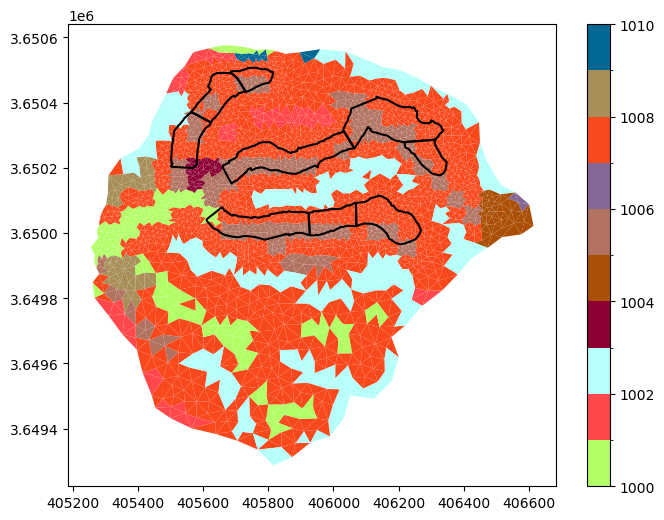

In [66]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, colorbar=True)

#watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
#                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca())


northplot_wet = north_Wet_gdf.boundary.plot(ax=plt.gca(), color='k')
northplot_typ1 = north_Typ1_gdf.boundary.plot(ax=plt.gca(), color='k')
northplot_typ2  = north_Typ2_gdf.boundary.plot(ax=plt.gca(), color='k')

southplot_wet = south_Wet_gdf.boundary.plot(ax=plt.gca(), color='k', label='Wetland HGF')
southplot_inc = south_Inc_gdf.boundary.plot(ax=plt.gca(), color='k', label='Incised HGF')
southplot_typ = south_Typ_gdf.boundary.plot(ax=plt.gca(), color='k', label = 'Intact Riparian HGF')

centralplot_wet = central_Wet_gdf.boundary.plot(ax=plt.gca(), color='k')
centralplot_inc = central_Inc_gdf.boundary.plot(ax=plt.gca(), color='k')
centralplot_typ = central_Typ_gdf.boundary.plot(ax=plt.gca(), color='k')




#plt.show()

In [65]:
nrcs

,mukey,geometry,residual saturation [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],thickness [m],permeability [m^2],porosity [-],source,ID,name
ATS ID,,,,,,,,,,,
1000,329660,"MULTIPOLYGON (((406586.239 3649280.558, 406604...",0.183022,0.000087,1.454444,1.648571,8.499286e-13,0.456116,NRCS,329660,NRCS-329660
1001,329677,"MULTIPOLYGON (((405854.118 3649287.539, 405751...",0.259364,0.000136,1.281699,1.826593,1.059670e-12,0.423589,NRCS,329677,NRCS-329677
1002,329678,"MULTIPOLYGON (((406352.508 3649390.773, 406359...",0.259346,0.000136,1.281759,1.826395,1.059558e-12,0.423518,NRCS,329678,NRCS-329678
1003,329679,"MULTIPOLYGON (((405534.324 3650131.452, 405525...",0.259364,0.000136,1.281699,1.826593,1.059670e-12,0.423589,NRCS,329679,NRCS-329679
1004,329680,"POLYGON ((406498.398 3649862.773, 406480.545 3...",0.260486,0.000136,1.279144,1.826593,9.000000e-13,0.424994,NRCS,329680,NRCS-329680
1005,329685,"MULTIPOLYGON (((405251.184 3649337.821, 405251...",0.177847,0.000188,1.530192,1.826593,1.525248e-12,0.391379,NRCS,329685,NRCS-329685
1006,329691,"POLYGON ((406603.323 3650040.819, 406589.846 3...",0.244114,0.000136,1.314532,2.030000,6.390761e-13,0.387142,NRCS,329691,NRCS-329691
1007,329700,"MULTIPOLYGON (((405535.038 3649290.599, 405554...",0.251097,0.000078,1.341898,1.787606,5.996212e-13,0.424000,NRCS,329700,NRCS-329700
1008,329710,"MULTIPOLYGON (((405341.534 3649820.87, 405321....",0.279415,0.000089,1.285173,1.775738,1.425234e-13,0.401387,NRCS,329710,NRCS-329710


2026-02-20 16:48:47,947 - root - INFO: Incoming shape area = 0.0001090799083422309
2026-02-20 16:48:47,951 - root - INFO: ... buffering incoming shape by = 0.0020834448229791747
2026-02-20 16:48:47,955 - root - INFO: ... buffered shape area = 0.00020823741719230238


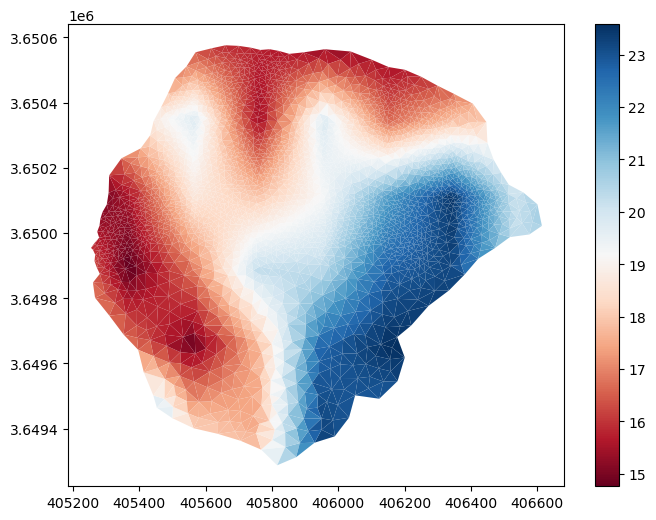

24.88
12.62


In [64]:
dtb = sources['depth to bedrock'].getDataset(watershed.exterior, watershed.crs)['band_1']

# the SoilGrids dataset is in cm --> convert to meters
dtb.values = dtb.values/100.
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')



gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

#cbar.ax.set_title('DTB [m]')
print(np.nanmax(dtb.values))
print(np.nanmin(dtb.values))

In [61]:
#This is the old version of add_polygonal_regions from WW version 1.5
def add_polygonal_regions(m2, polygons, labels=None, kind='watershed', volume=False):

    """Label m2 with region(s) for each polygon.
    Always adds a surface region; if volume also adds a volume region
    for extrusion in 3D.
    
    Parameters
    ----------
    m2 : mesh.Mesh2D
      The mesh to label.
      
    polygons : iterable[shapely.Polygon]
      The polygons covering each watershed.
      
    labels : iterable[str], optional
      Names of the polygons (often HUC strings)
      
    kind : str, optional
      The kind of polygon to add -- this is only used to generate
      labels.  Default is 'watershed'.

    volume : bool, optional
      If true, also add the volumetric region below the polygon that
      will be extruded in a 3D mesh eventually.
    """

    if labels is None:
        labels = _get_labels(polygons)
    assert (len(labels) == len(polygons))

    partitions = [list() for p in polygons]

    for c in range(m2.num_cells):
        cc = m2.centroids[c]
        cc = shapely.geometry.Point(cc[0], cc[1])

        for i, p in enumerate(polygons):
            if p.contains(cc):
                partitions[i].append(c)
    i = 0
    for label, part in zip(labels, partitions):

        if len(part) > 0:
            # add a region, denoting this one as "to extrude".  This
            # will become the volume region

            m2.next_available_labeled_setid = 200 + i
            i = 5 + i
            print(i)
            setid = m2.next_available_labeled_setid
            ls = watershed_workflow.mesh.LabeledSet(label, int(setid), 'CELL', part)
            m2.labeled_sets.append(ls)
            ls.to_extrude = True

            # add a second region, denoting this one as the top surface of faces
            setid2 = m2.next_available_labeled_setid+1
            ls2 = watershed_workflow.mesh.LabeledSet(label + ' surface', setid2, 'CELL', part)
            m2.labeled_sets.append(ls2)

    return partitions

In [62]:
import watershed_workflow.regions as regions
##This is the old version of the add_watershed_regions_and_outlets function from WW
def add_splithucs_to_mesh(m2,

                                      hucs,
                                      outlets=None,
                                      outlet_width=10,
                                      labels=None,
                                      exterior_outlet=True):

    """Add four labeled sets to m2 for each polygon:
    - cells in the polygon, to be extruded
    - cells in the polygon, to be kept as faces upon extrusion
    - boundary of the polygon (edges, kept as faces)
    - outlet of the polygon (edges, kept as faces, within outlet width
      of the outlet)

    Parameters
    ----------
    m2 : mesh.Mesh2D
      The mesh to label.
      
    hucs : iterable[shapely.Polygon] or SplitHUCs object
      Watershed polygons.
      
    outlets : iterable[shapely.Point], optional
      If provided, the outlet points.  If SplitHUCs are provided,
      outlets are in that object and this must be None.
      
    outlet_width : float, optional
      How wide should the outlet region be?  Note this should include
      not just the river width, but more realistically the best
      resolved floodplain, or 1-2 face-widths, whichever is bigger.

    labels : iterable[str], optional
      Name of the polygons.  If SplitHUCs are provided, HUC names are
      used as the default.

    exterior_outlet : bool, optional
      If true, find the outlet point that intersects the boundary and
      include regions around that outlet as well.

    """

    if isinstance(hucs, list):
        polygons = hucs
    else:
        polygons = list(hucs.polygons())
        if outlets is None and hasattr(hucs, 'polygon_outlets'):
            outlets = hucs.polygon_outlets

    if labels is None:
        labels = _get_labels(hucs)

    if outlets is None:
        outlets = [None, ] * len(polygons)

    assert (len(labels) == len(polygons))

    # this adds the first two sets
    partitions = add_polygonal_regions(m2, polygons, labels, volume=True)

    # find a list of faces on the boundary of these sets of triangles

    # UGLY HACK -- create a Mesh2D object with nan coordinates and
    # edges that are unordered nodes.  This could never be used for
    # anything geometric, but may allow us to exploit the existing
    # topologic routines in Mesh2D

    def inside_ball(outlet, edge):
        n1 = m2.coords[edge[0]]
        n2 = m2.coords[edge[1]]
        c = (n1+n2) / 2.
        close = watershed_workflow.utils.isClose(outlet, tuple(c[0:2]), outlet_width)
        return close
    i = 0
    for label, tris, outlet in zip(labels, partitions, outlets):
        
        subdomain_conn = [list(m2.conn[tri]) for tri in tris]
        subdomain_nodes = set([c for e in subdomain_conn for c in e])
        subdomain_coords = np.array([m2.coords[c] for c in subdomain_nodes])
        m2h = watershed_workflow.mesh.Mesh2D(subdomain_coords,
                                             subdomain_conn,
                                             check_handedness=False,
                                             validate=False)
        edges = [(int(e[0]), int(e[1])) for e in m2h.boundary_edges]
        ls = watershed_workflow.mesh.LabeledSet(label + ' boundary',
                                                m2.next_available_labeled_setid+2+i, 'FACE', edges)

        ls.to_extrude = True  # this marker tells the extrusion routine to not limit it to the surface

        m2.labeled_sets.append(ls)

        # every polygon now has an outlet -- find the boundary faces near that outlet

        if outlet is not None:
            outlet_faces = [e for e in m2h.boundary_edges if inside_ball(outlet, e)]
            edges = [(int(e[0]), int(e[1])) for e in outlet_faces]
            ls = watershed_workflow.mesh.LabeledSet(label + ' outlet',
                                                    m2.next_available_labeled_setid+3+i, 'FACE',
                                                    edges)
            ls.to_extrude = True  # this marker tells the extrusion routine
            # to not limit it to the surface
            m2.labeled_sets.append(ls)
        i = i+5

In [63]:

add_splithucs_to_mesh(
    m2,
    outlets = None,
    hucs=reachShapes,
    labels=reachLabels,
    outlet_width=5,
    exterior_outlet=False
)

5
10
15
20
25
30
35
40
45
50
55


In [64]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

41 : CELL : "Deciduous Forest"
42 : CELL : "Evergreen Forest"
43 : CELL : "Mixed Forest"
52 : CELL : "Shrub/Scrub"
81 : CELL : "Pasture/Hay"
90 : CELL : "Woody Wetlands"
10000 : FACE : "north_Typ2_out"
10001 : CELL : "north_Typ2_out cells"
10002 : FACE : "north_Wet_out"
10003 : CELL : "north_Wet_out cells"
10004 : FACE : "north_Typ1_out"
10005 : CELL : "north_Typ1_out cells"
10006 : FACE : "central_Inc_out"
10007 : CELL : "central_Inc_out cells"
10008 : FACE : "central_Typ_out"
10009 : CELL : "central_Typ_out cells"
10010 : FACE : "central_Wet_out"
10011 : CELL : "central_Wet_out cells"
10012 : FACE : "south_Inc_out"
10013 : CELL : "south_Inc_out cells"
10014 : FACE : "south_Typ_out"
10015 : CELL : "south_Typ_out cells"
10016 : FACE : "south_Wet_out"
10017 : CELL : "south_Wet_out cells"
10018 : FACE : "southFlume_out"
10019 : CELL : "southFlume_out cells"
10020 : FACE : "centralFlume_out"
10021 : CELL : "centralFlume_out cells"
10022 : CELL : "0"
10023 : CELL : "0 surface"
10024 : FACE

In [65]:
glhymps = sources['geologic structure'].getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, out_crs=crs)
glhymps = watershed_workflow.soil_properties.mangleGLHYMPSProperties(glhymps,
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# intersect with the buffered geometry -- don't keep extras
glhymps = glhymps[glhymps.intersects(watershed.exterior.buffer(10))]
glhymps

2026-02-09 22:45:55,041 - root - INFO: fixing column: geometry


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,1791324,GLHYMPS-1791324,GLHYMPS,1.258925e-11,1.2,0.28,0.001,2.0,0.01,"MULTIPOLYGON (((374024.532 3361377.325, 374067..."


In [66]:
# quality check -- make sure glymps shapes cover the watershed
print(glhymps.union_all().contains(watershed.exterior))
glhymps

True


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,1791324,GLHYMPS-1791324,GLHYMPS,1.258925e-11,1.2,0.28,0.001,2.0,0.01,"MULTIPOLYGON (((374024.532 3361377.325, 374067..."


In [67]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

ID                             False
name                           False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [68]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [69]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
output_filenames['subsurface_properties'] = toOutput(f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(output_filenames['subsurface_properties'])
subsurface_props

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,1791324,GLHYMPS-1791324,GLHYMPS,1.258925e-11,0.280000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((374024.532 3361377.325, 374067...",NaN,NaN
1000,329660,NRCS-329660,NRCS,8.499286e-13,0.456116,0.000087,1.454444,0.183022,"MULTIPOLYGON (((406586.239 3649280.558, 406604...",329660.0,1.648571
1001,329677,NRCS-329677,NRCS,1.059670e-12,0.423589,0.000136,1.281699,0.259364,"MULTIPOLYGON (((405854.118 3649287.539, 405751...",329677.0,1.826593
1002,329678,NRCS-329678,NRCS,1.059558e-12,0.423518,0.000136,1.281759,0.259346,"MULTIPOLYGON (((406352.508 3649390.773, 406359...",329678.0,1.826395
1003,329679,NRCS-329679,NRCS,1.059670e-12,0.423589,0.000136,1.281699,0.259364,"MULTIPOLYGON (((405534.324 3650131.452, 405525...",329679.0,1.826593
1004,329680,NRCS-329680,NRCS,9.000000e-13,0.424994,0.000136,1.279144,0.260486,"POLYGON ((406498.398 3649862.773, 406480.545 3...",329680.0,1.826593
1005,329685,NRCS-329685,NRCS,1.525248e-12,0.391379,0.000188,1.530192,0.177847,"MULTIPOLYGON (((405251.184 3649337.821, 405251...",329685.0,1.826593
1006,329691,NRCS-329691,NRCS,6.390761e-13,0.387142,0.000136,1.314532,0.244114,"POLYGON ((406603.323 3650040.819, 406589.846 3...",329691.0,2.030000
1007,329700,NRCS-329700,NRCS,5.996212e-13,0.424000,0.000078,1.341898,0.251097,"MULTIPOLYGON (((405535.038 3649290.599, 405554...",329700.0,1.787606
1008,329710,NRCS-329710,NRCS,1.425234e-13,0.401387,0.000089,1.285173,0.279415,"MULTIPOLYGON (((405341.534 3649820.87, 405321....",329710.0,1.775738


In [70]:
# Generate a dz structure for the top 2.1 m of soil -- it appears from above that the soil thickness is ~ 2m
#
# here we try for 3 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2.1m thick soil

dzs, res = watershed_workflow.mesh.optimizeDzs(0.1, 1, 2.1, 10)
print(dzs)

[0.10089715 0.10271008 0.10681804 0.11402025 0.16333203 0.29359606
 0.48552949 0.73309689]


In [71]:

#check that the dzs add up to >2 m

dzs = [0.1, 0.1, 0.1, 0.1, 0.15, 0.3, 0.5, 0.75]

sum(dzs)

2.1

In [72]:
# a 2 m soil thickness and a maximum of 25.7 m depth to bedrock suggests a
# soil layer of ~24 m, so 6 4 m cells and a bedrock confining layer
dzs = dzs + [4] + [4] + [4] + [4] + [4] + [4] + [1]


In [73]:
print(sum(dzs))

27.1


In [74]:
## layer extrusion
DTB = m2.cell_data['dtb'].values
#soil_color = m2.cell_data['soil_color'].values
#geo_color = m2.cell_data['geology_color'].values
#soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- add the layers
depth = 0
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # to set the layer type, we check whether it is
    #   * above the soil thickness (it is soil)
    #   * below the depth to bedrock (it is bedrock)
    #   * else it is geologic layer
    # -- set the depth as the cell midpoint
    depth += 0.5 * dz
    
    # -- bedrock (999) or geologic layer (from geo_color)
    br_or_geo = np.where(depth < DTB, 100, 999)
    
    # -- are we in the soil horizons? If so, append soil color
    mat_id = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)
    depth += 0.5 * dz
    layer_mat_ids.append(mat_id)
    
# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
subsurface_props_used



2026-02-09 22:45:57,505 - root - INFO: Cell summary:
2026-02-09 22:45:57,512 - root - INFO: ------------------------------------------------------------
2026-02-09 22:45:57,517 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2026-02-09 22:45:57,527 - root - INFO: ------------------------------------------------------------
2026-02-09 22:45:57,535 - root - INFO:  00 	| 00 	| 1007 	|   0.100000 	|   0.000000
2026-02-09 22:45:57,540 - root - INFO:  01 	| 01 	| 1007 	|   0.100000 	|   0.100000
2026-02-09 22:45:57,552 - root - INFO:  02 	| 02 	| 1007 	|   0.100000 	|   0.200000
2026-02-09 22:45:57,560 - root - INFO:  03 	| 03 	| 1007 	|   0.100000 	|   0.300000
2026-02-09 22:45:57,561 - root - INFO:  04 	| 04 	| 1007 	|   0.150000 	|   0.400000
2026-02-09 22:45:57,561 - root - INFO:  05 	| 05 	| 1007 	|   0.300000 	|   0.550000
2026-02-09 22:45:57,562 - root - INFO:  06 	| 06 	| 1007 	|   0.500000 	|   0.850000
2026-02-09 22:45:57,564 - root - INFO:  07 	| 07 	| 1007 	|   0.750000 	|   1.3

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,1791324,GLHYMPS-1791324,GLHYMPS,1.258925e-11,0.280000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((374024.532 3361377.325, 374067...",NaN,NaN
999,999,bedrock,n/a,1.000000e-16,0.050000,0.000019,3.000000,0.010000,None,NaN,NaN
1000,329660,NRCS-329660,NRCS,8.499286e-13,0.456116,0.000087,1.454444,0.183022,"MULTIPOLYGON (((406586.239 3649280.558, 406604...",329660.0,1.648571
1001,329677,NRCS-329677,NRCS,1.059670e-12,0.423589,0.000136,1.281699,0.259364,"MULTIPOLYGON (((405854.118 3649287.539, 405751...",329677.0,1.826593
1002,329678,NRCS-329678,NRCS,1.059558e-12,0.423518,0.000136,1.281759,0.259346,"MULTIPOLYGON (((406352.508 3649390.773, 406359...",329678.0,1.826395
1003,329679,NRCS-329679,NRCS,1.059670e-12,0.423589,0.000136,1.281699,0.259364,"MULTIPOLYGON (((405534.324 3650131.452, 405525...",329679.0,1.826593
1004,329680,NRCS-329680,NRCS,9.000000e-13,0.424994,0.000136,1.279144,0.260486,"POLYGON ((406498.398 3649862.773, 406480.545 3...",329680.0,1.826593
1005,329685,NRCS-329685,NRCS,1.525248e-12,0.391379,0.000188,1.530192,0.177847,"MULTIPOLYGON (((405251.184 3649337.821, 405251...",329685.0,1.826593
1006,329691,NRCS-329691,NRCS,6.390761e-13,0.387142,0.000136,1.314532,0.244114,"POLYGON ((406603.323 3650040.819, 406589.846 3...",329691.0,2.030000
1007,329700,NRCS-329700,NRCS,5.996212e-13,0.424000,0.000078,1.341898,0.251097,"MULTIPOLYGON (((405535.038 3649290.599, 405554...",329700.0,1.787606


In [75]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)


print(m3.material_ids_list)


[np.int32(100), np.int32(999), np.int32(1000), np.int32(1001), np.int32(1002), np.int32(1003), np.int32(1004), np.int32(1005), np.int32(1006), np.int32(1007), np.int32(1008), np.int32(1009)]


In [76]:
config['start_date'] = start
config['end_date'] = end

In [77]:
# save to disk
filename = os.path.join('output_data', 'shambley_wwv2_8m')

if watershed_workflow.mesh.exodus is not None:
    try:
        os.remove(filename+'.exo')
    except FileNotFoundError:
        pass
    m3.writeExodus(filename+'.exo')



You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: output_data/shambley_wwv2_8m.exo


2026-02-09 22:45:58,470 - root - INFO: adding side set: 1
2026-02-09 22:45:58,492 - root - INFO: adding side set: 2
2026-02-09 22:45:58,498 - root - INFO: adding side set: 3
2026-02-09 22:45:58,502 - root - INFO: adding side set: 41
2026-02-09 22:45:58,505 - root - INFO: adding side set: 42
2026-02-09 22:45:58,510 - root - INFO: adding side set: 43
2026-02-09 22:45:58,531 - root - INFO: adding side set: 52
2026-02-09 22:45:58,551 - root - INFO: adding side set: 81
2026-02-09 22:45:58,565 - root - INFO: adding side set: 90
2026-02-09 22:45:58,568 - root - INFO: adding side set: 10000
2026-02-09 22:45:58,574 - root - INFO: adding side set: 10001
2026-02-09 22:45:58,580 - root - INFO: adding side set: 10002
2026-02-09 22:45:58,584 - root - INFO: adding side set: 10003
2026-02-09 22:45:58,588 - root - INFO: adding side set: 10004
2026-02-09 22:45:58,591 - root - INFO: adding side set: 10005
2026-02-09 22:45:58,594 - root - INFO: adding side set: 10006
2026-02-09 22:45:58,597 - root - INFO:

Closing exodus file: output_data/shambley_wwv2_8m.exo


In [78]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')
    #print(f"Cell IDs: {ls.ent_ids}")


#print('')
#print('Extruded 3D labeled sets')
#print('------------------------')
#for ls in m3.labeled_sets:
#    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')


print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    #cell_ids = m3.get_set_cell_ids('ls.setid')
    #print(cell_ids)

2D labeled sets
---------------
41 : CELL : 578 : "Deciduous Forest"
42 : CELL : 2487 : "Evergreen Forest"
43 : CELL : 1500 : "Mixed Forest"
52 : CELL : 136 : "Shrub/Scrub"
81 : CELL : 16 : "Pasture/Hay"
90 : CELL : 60 : "Woody Wetlands"
10000 : FACE : 3 : "north_Typ2_out"
10001 : CELL : 3 : "north_Typ2_out cells"
10002 : FACE : 3 : "north_Wet_out"
10003 : CELL : 3 : "north_Wet_out cells"
10004 : FACE : 3 : "north_Typ1_out"
10005 : CELL : 3 : "north_Typ1_out cells"
10006 : FACE : 3 : "central_Inc_out"
10007 : CELL : 3 : "central_Inc_out cells"
10008 : FACE : 3 : "central_Typ_out"
10009 : CELL : 3 : "central_Typ_out cells"
10010 : FACE : 3 : "central_Wet_out"
10011 : CELL : 3 : "central_Wet_out cells"
10012 : FACE : 3 : "south_Inc_out"
10013 : CELL : 3 : "south_Inc_out cells"
10014 : FACE : 3 : "south_Typ_out"
10015 : CELL : 3 : "south_Typ_out cells"
10016 : FACE : 3 : "south_Wet_out"
10017 : CELL : 3 : "south_Wet_out cells"
10018 : FACE : 3 : "southFlume_out"
10019 : CELL : 3 : "southF

In [79]:
### Writing ATS Input Files

# Note that each of these are defined as functions so we can reuse them for all three input files.

# add the subsurface and surface domains
#
# Note this also adds a "computational domain" region to the region list, and a vis spec 
# for "domain"
def add_domains(main_list, mesh, surface_region='surface', snow=True, canopy=True):
    ats_input_spec.public.add_domain(main_list, 
                                 domain_name='domain', 
                                 dimension=3, 
                                 mesh_type='read mesh file',
                                 mesh_args={'file':mesh})
    if surface_region:
        main_list['mesh']['domain']['build columns from set'] = surface_region    
    
        # Note this also adds a "surface domain" region to the region list and a vis spec for 
        # "surface"
        ats_input_spec.public.add_domain(main_list,
                                domain_name='surface',
                                dimension=2,
                                mesh_type='surface',
                                mesh_args={'surface sideset name':'surface'})
    if snow:
        # Add the snow and canopy domains, which are aliases to the surface
        ats_input_spec.public.add_domain(main_list,
                                domain_name='snow',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})
    if canopy:
        ats_input_spec.public.add_domain(main_list,
                                domain_name='canopy',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})


In [80]:
def add_land_cover(main_list):
    # next write a land-cover section for each NLCD type
    for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
        ats_input_spec.public.set_land_cover_default_constants(main_list, nlcd_name)

    land_cover_list = main_list['state']['model parameters']['land cover types']
    # update some defaults for
    # ['Other', 'Deciduous Forest']
    # note, these are from the CLM Technical Note v4.5
    #
    # Rooting depth curves from CLM TN 4.5 table 8.3
    #
    # Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
    # curves we are using (ETC -- add paper citation about this topic).  Likely they need
    # to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
    # factor of 10 converts to [Pa]
    #
    # Note, albedo of canopy taken from CLM TN 4.5 table 3.1

    #Deciduous Forest is BDT temperate in the CLM 
    land_cover_list['Deciduous Forest']['rooting profile alpha [-]'] = 6.0
    land_cover_list['Deciduous Forest']['rooting profile beta [-]'] = 2.0
    land_cover_list['Deciduous Forest']['rooting depth max [m]'] = 10.0
    land_cover_list['Deciduous Forest']['capillary pressure at fully closed stomata [Pa]'] = 224000 * .10
    land_cover_list['Deciduous Forest']['capillary pressure at fully open stomata [Pa]'] = 35000 * .10
    land_cover_list['Deciduous Forest']['albedo of canopy [-]'] = 0.1
    
    #Evergreen Forest is NET temperate in the CLM 
    land_cover_list['Evergreen Forest']['rooting profile alpha [-]'] = 7.0
    land_cover_list['Evergreen Forest']['rooting profile beta [-]'] = 2.0
    land_cover_list['Evergreen Forest']['rooting depth max [m]'] = 10.0
    land_cover_list['Evergreen Forest']['capillary pressure at fully closed stomata [Pa]'] = 255000 * .10
    land_cover_list['Evergreen Forest']['capillary pressure at fully open stomata [Pa]'] = 66000 * .10
    land_cover_list['Evergreen Forest']['albedo of canopy [-]'] = 0.07
    
    #Mixed Forest is 50/50 BTD/NET temperate in the CLM   
    land_cover_list['Mixed Forest']['rooting profile alpha [-]'] = 6.5
    land_cover_list['Mixed Forest']['rooting profile beta [-]'] = 2.0
    land_cover_list['Mixed Forest']['rooting depth max [m]'] = 10.0
    land_cover_list['Mixed Forest']['capillary pressure at fully closed stomata [Pa]'] = 239500 * .10
    land_cover_list['Mixed Forest']['capillary pressure at fully open stomata [Pa]'] = 50500 * .10
    land_cover_list['Mixed Forest']['albedo of canopy [-]'] = 0.085

    #Shrub/Scrub is BDS temperate in the CLM   
    land_cover_list['Shrub/Scrub']['rooting profile alpha [-]'] = 7.0
    land_cover_list['Shrub/Scrub']['rooting profile beta [-]'] = 1.5
    land_cover_list['Shrub/Scrub']['rooting depth max [m]'] = 10.0
    land_cover_list['Shrub/Scrub']['capillary pressure at fully closed stomata [Pa]'] = 428000 * .10
    land_cover_list['Shrub/Scrub']['capillary pressure at fully open stomata [Pa]'] = 83000 * .10
    land_cover_list['Shrub/Scrub']['albedo of canopy [-]'] = 0.1
    
    #Pasture/Hay is C4 Grass in the CLM   
    land_cover_list['Pasture/Hay']['rooting profile alpha [-]'] = 11.0
    land_cover_list['Pasture/Hay']['rooting profile beta [-]'] = 2.0
    land_cover_list['Pasture/Hay']['rooting depth max [m]'] = 10.0
    land_cover_list["Pasture/Hay"]['capillary pressure at fully closed stomata [Pa]'] = 275000 * .10
    land_cover_list["Pasture/Hay"]['capillary pressure at fully open stomata [Pa]'] = 74000 * .10
    land_cover_list['Pasture/Hay']['albedo of canopy [-]'] = 0.11

    #Woody Wetlands is BDT temperate in the CLM   
    land_cover_list['Woody Wetlands']['rooting profile alpha [-]'] = 6.0
    land_cover_list['Woody Wetlands']['rooting profile beta [-]'] = 2.0
    land_cover_list['Woody Wetlands']['rooting depth max [m]'] = 10.0
    land_cover_list["Woody Wetlands"]['capillary pressure at fully closed stomata [Pa]'] = 224000 * .10
    land_cover_list["Woody Wetlands"]['capillary pressure at fully open stomata [Pa]'] = 35000 * .10
    land_cover_list['Woody Wetlands']['albedo of canopy [-]'] = 0.10

In [81]:
# add soil sets: note we need a way to name the set, so we use, e.g. SSURGO-MUKEY.
def soil_set_name(ats_id):
    return subsurface_props_used.loc[ats_id, 'name']

def add_soil_properties(main_list):
    # add soil material ID regions, porosity, permeability, and WRMs
    for ats_id in subsurface_props_used.index:
        props = subsurface_props_used.loc[ats_id]
        set_name = soil_set_name(ats_id)
        
        if props['van Genuchten n [-]'] < 1.5:
            smoothing_interval = 0.01
        else:
            smoothing_interval = 0.0
        
        ats_input_spec.public.add_soil_type(main_list, set_name, ats_id, output_filenames['mesh'],
                                            float(props['porosity [-]']),
                                            float(props['permeability [m^2]']), 1.e-7,
                                            float(props['van Genuchten alpha [Pa^-1]']),
                                            float(props['van Genuchten n [-]']),
                                            float(props['residual saturation [-]']),
                                            float(smoothing_interval))    



In [82]:
# get an ATS "main" input spec list -- note, this is a dummy and is not used to write any files yet
def get_main(steadystate=False, canopy=False):
    main_list = ats_input_spec.public.get_main()

    # add the mesh and all domains
    mesh = os.path.join('..', output_filenames['mesh'])
    add_domains(main_list, mesh)

    # add labeled sets
    for ls in m3.labeled_sets:
        print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')
        ats_input_spec.public.add_region_labeled_set(main_list, ls.name, ls.setid, mesh, ls.entity)
    for ss in m3.side_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ss.name, ss.setid, mesh, 'FACE')
    
    # add land cover
    add_land_cover(main_list)

    # add soil properties
    add_soil_properties(main_list)
        
    ats_input_spec.public.add_observations_water_balance(
        main_list, "computational domain", "surface domain", "external sides",
        has_canopy=canopy
    )

    return main_list

In [83]:
def populate_basic_properties(xml, main_xml):
    """This function updates an xml object with the above properties for mesh, regions, soil props, and lc props"""
    # find and replace the mesh list
    xml.replace('mesh', asearch.child_by_name(main_xml, 'mesh'))

    # find and replace the regions list
    xml.replace('regions', asearch.child_by_name(main_xml, 'regions'))

    # update the observations list
    obs = next(i for (i,el) in enumerate(xml) if el.get('name') == 'observations')
    xml[obs] = asearch.child_by_name(main_xml, 'observations')

    # update all model parameters lists
    xml_parlist = asearch.find_path(xml, ['state', 'model parameters'], no_skip=True)
    for parlist in asearch.find_path(main_xml, ['state', 'model parameters'], no_skip=True):
        try:
            xml_parlist.replace(parlist.getName(), parlist)
        except aerrors.MissingXMLError:
            xml_parlist.append(parlist)

    # update all evaluator lists
    xml_elist = asearch.find_path(xml, ['state', 'evaluators'], no_skip=True)
    for elist in asearch.find_path(main_xml, ['state', 'evaluators'], no_skip=True):
        try:
            xml_elist.replace(elist.getName(), elist)
        except aerrors.MissingXMLError:
            xml_elist.append(elist)    
    
    # find and replace land cover
    mp_list = asearch.find_path(xml, ['state', 'model parameters'], no_skip=True)
    lc_list = asearch.find_path(main_xml, ['state', 'model parameters', 'land cover types'], no_skip=True)
    
    try:
        mp_list.replace('land cover types', lc_list)
    except aerrors.MissingXMLError:
        mp_list.append(lc_list)


In [84]:
def write_spinup_steadystate(name, precip_mean, **kwargs):
    # create the main list
    main = get_main(steadystate=True)

    # set precip to 0.6 * the mean precip value
    precip = main['state']['evaluators'].append_empty('surface-precipitation')
    precip.set_type('independent variable constant', ats_input_spec.public.known_specs['evaluator-independent-variable-constant-spec'])
    precip['value'] = float(precip_mean * .6)

    
    # load the template file
    prefix = 'steadystate'
    xml = aio.fromFile(toInput(f'{prefix}-template.xml'))
    
    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)

    # write to disk
    output_filenames[f'ats_xml_{prefix}'] = toWorkingDir(f'{name}-{prefix}.xml')
    filename = output_filenames[f'ats_xml_{prefix}']
    aio.toFile(xml, filename)

    # create a run directory
    output_filenames[f'ats_rundir_{prefix}'] = toWorkingDir(f'{name}-{prefix}')
    rundir = output_filenames[f'ats_rundir_{prefix}']
    os.makedirs(rundir, exist_ok=True)

    os.makedirs(rundir, exist_ok=True)

In [86]:
def write_transient(name, cyclic_steadystate=False, **kwargs):
    # make a unique name based on options
    logging.info(f'Writing transient: {name}')

    if cyclic_steadystate:
        prefix = 'cyclic_steadystate'
        previous = 'steadystate'
    else:
        prefix = 'transient'
        previous = 'cyclic_steadystate'

    main = get_main(steadystate=False, canopy=True)

    # add the DayMet evaluators
    if cyclic_steadystate:
        daymet_filename = output_filenames['meteorology_cyclic']
    else:
        daymet_filename = output_filenames['meteorology_transient']
    ats_input_spec.public.add_daymet_box_evaluators(main, os.path.join('..', daymet_filename), True)

    # add the LAI filenames
    if cyclic_steadystate:
        lai_filename = output_filenames['nlcd_lai_cyclic_steadystate']
    else:
        lai_filename = output_filenames['nlcd_lai_transient']
    ats_input_spec.public.add_lai_point_evaluators(main, os.path.join('..', lai_filename), list(nlcd_labels_dict.values()))
    
    # load the template file
    template_filename = toInput(f'{prefix}-template.xml')
    xml = aio.fromFile(template_filename)

    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)
    
    # October 1 is the first day of the water year and the 274th day of the year

    if cyclic_steadystate:
        start_day = 732
        end_day = 732 + (4  * 365 )
    else:
        start_day = 274
        end_day = 274 + (end - start).days 
        
    par = asearch.find_path(xml, ['cycle driver', 'start time'])
    par.setValue(start_day)

    par = asearch.find_path(xml, ['cycle driver', 'end time'])
    par.setValue(end_day)
    
    # update the restart filenames
    for var in asearch.findall_path(xml, ['initial conditions', 'restart file']):
        var.setValue(os.path.join('..', output_filenames[f'ats_rundir_{previous}'], 'checkpoint_final.h5'))
   scalebar = AnchoredSizeBar(ax.transData,
                           20, '20 m', 'lower center', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
    # write to disk and make a directory for running the run
    output_filenames[f'ats_xml_{prefix}'] = toWorkingDir(f'{name}-{prefix}.xml')
    filename = output_filenames[f'ats_xml_{prefix}']

    output_filenames[f'ats_rundir_{prefix}'] = toWorkingDir(f'{name}-{prefix}')
    rundir = output_filenames[f'ats_rundir_{prefix}']

    aio.toFile(xml, filename)
    os.makedirs(rundir, exist_ok=True)

IndentationError: unindent does not match any outer indentation level (<string>, line 54)

In [ ]:
output_filenames['mesh'] = toOutput(f'{name}.exo')
output_filenames['ats_rundir_cyclic_steadystate'] = toOutput(f'{prev}.exo')
def toInput(filename):
    return os.path.join('input_data', filename)

def toWorkingDir(filename):
    return os.path.join('output_data', filename)
   

In [ ]:
#Annual Precip is 56 inches per year or 4.5104e-8 m/s
precip_mean = 0.000000045104
write_spinup_steadystate(name, precip_mean)

In [ ]:
# write transient data to disk
filename = ('shambley_cyclic.h5')
output_filenames['meteorology_cyclic'] = filename

filename = ('shambley_met_hourly.h5')
output_filenames['meteorology_transient'] = filename

write_transient(name, True)

In [ ]:
write_transient(name, False)